# Masterclass: Clasificación Supervisada (de 0 a producción)
**Caso práctico:** Predicción de mora (`mora_30d_next3m`) con `dataset_mora.csv`  
**Autor:** Josef Renato Rodríguez Mallma  
**Repositorio oficial del curso:** `ML-course` (GitHub)  

> Objetivo: construir un pipeline completo **estilo banca/riesgo**:  
EDA mínima → split temporal **TRAIN/TEST/OOT** → limpieza/selección (correlación + MI + PSI) → modelos → umbral → interpretabilidad → checklist de producción.


## Agenda
1. Contexto de negocio (riesgo / mora) y definición del target  
2. Carga de datos (desde GitHub) + validaciones rápidas  
3. Split temporal correcto: **TRAIN / TEST / OOT** (anti-leakage)  
4. Tipificación de variables: numéricas / flags / categóricas  
5. Redundancia estructural: correlación, multicolinealidad (VIF opcional)  
6. Señal predictiva: correlación vs target (Spearman) + Mutual Information (MI)  
7. Estabilidad temporal: PSI (TRAIN vs TEST, TRAIN vs OOT, mensual) + drift del target + drift por segmento  
8. Modelamiento: Logistic Regression (baseline) + RandomForest + Gradient Boosting (sklearn)  
9. Selección de umbral (threshold) en TEST y validación final en OOT  
10. Interpretabilidad (coeficientes + permutation importance)  
11. Checklist de producción (drift, monitoreo, gobernanza)


In [1]:
# ==========================================
# 1) Setup (imports + configuración)
# ==========================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix
)

from sklearn.inspection import permutation_importance

# (Opcional) Para VIF
# Si no tienes statsmodels instalado, comenta estas líneas y omite la celda de VIF
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    STATS_MODELS_OK = True
except Exception:
    STATS_MODELS_OK = False

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

print("Listo ✅")


Listo ✅


## 2) Carga del dataset (desde GitHub)

Usaremos el dataset del repo del curso.  
**Importante:** `pd.read_csv` necesita el link `raw` (no el link “blob”).  

- Web: `https://github.com/josefrodrim/ML-course/blob/main/data/dataset_mora.csv`  
- Raw: `https://raw.githubusercontent.com/josefrodrim/ML-course/main/data/dataset_mora.csv`

Incluimos fallback a local (por si se ejecuta sin internet).


In [2]:
# ==========================================
# 2) Carga de datos (GitHub raw) + fallback local
# ==========================================
GITHUB_RAW = "https://raw.githubusercontent.com/josefrodrim/ML-course/main/data/dataset_mora.csv"
LOCAL_PATH = "data/dataset_mora.csv"  # si clonan el repo y ejecutan desde la raíz

try:
    df = pd.read_csv(GITHUB_RAW)
    print("Dataset cargado desde GitHub ")
except Exception as e:
    print("No se pudo cargar desde GitHub. Intentando local...")
    df = pd.read_csv(LOCAL_PATH)
    print("Dataset cargado desde ruta local ")

print("Shape:", df.shape)
display(df.head())


Dataset cargado desde GitHub 
Shape: (36180, 18)


,id_cliente,periodo,edad,sexo,region,segmento,ingreso_mensual,score_bureau,num_lineas,max_mora_12m,mora_30d_12m,saldo_total,utilizacion_tc,antig_laboral_anios,antig_banca_anios,producto_principal,canal_origen,mora_30d_next3m
0,C001468,202508,44,F,Lima,C,1216.74,619.0,0,0,0,2626.98,0.7406391036855144,6.0,2.2,Hipotecario,Digital,0
1,C000819,202412,28,M,Norte,A,4383.33,608.0,3,0,0,9757.52,0.613334504526248,1.6,1.1,TC,Tienda,1
2,C000739,202410,35,M,Lima,B,3560.49,611.0,3,0,1,3702.30,0.09751335927199843,4.7,1.4,Pyme,Digital,0
3,C001080,202406,26,M,Norte,B,2505.25,690.0,4,1,1,3479.64,0.1416807201234781,10.0,0.0,PL,Digital,0
4,C000736,202406,62,M,Lima,A,1866.13,717.0,2,1,0,2274.58,0.24411083948236922,8.3,2.3,Hipotecario,FuerzaVenta,0


## 3) Validaciones rápidas (schema, nulos, target)

- Revisamos tipos y nulos
- Aseguramos que el `target` sea 0/1
- Normalizamos `periodo` (YYYYMM) para split temporal


In [3]:
# ==========================================
# 3) Validaciones rápidas
# ==========================================
display(df.dtypes)

nulls = df.isna().sum().sort_values(ascending=False)
print("\nTop nulos:")
display(nulls.head(20))

target = "mora_30d_next3m"
time_col = "periodo"

# Asegurar target 0/1
if df[target].dtype == "O":
    df[target] = df[target].map({"No": 0, "Sí": 1, "Si": 1, "NO": 0, "SI": 1}).astype("float")

df[target] = df[target].astype(int)

print("\nDistribución target:")
display(df[target].value_counts().sort_index())
print("Tasa de mora:", df[target].mean())


id_cliente                 str
periodo                  int64
edad                     int64
sexo                       str
region                     str
segmento                   str
ingreso_mensual            str
score_bureau           float64
num_lineas               int64
max_mora_12m             int64
mora_30d_12m             int64
saldo_total            float64
utilizacion_tc             str
antig_laboral_anios    float64
antig_banca_anios      float64
producto_principal         str
canal_origen               str
mora_30d_next3m          int64
dtype: object


Top nulos:


score_bureau           790
ingreso_mensual        753
utilizacion_tc         709
antig_laboral_anios    705
saldo_total            691
region                 385
producto_principal     371
sexo                   365
canal_origen           348
segmento               344
id_cliente               0
antig_banca_anios        0
max_mora_12m             0
mora_30d_12m             0
periodo                  0
num_lineas               0
edad                     0
mora_30d_next3m          0
dtype: int64


Distribución target:


mora_30d_next3m
0    29764
1     6416
Name: count, dtype: int64

Tasa de mora: 0.1773355444997236


In [4]:
# ==========================================
# Normalización de 'periodo' a YYYYMM (int)
# ==========================================
def to_yyyymm(x):
    try:
        return int(str(x)[:6])
    except Exception:
        return np.nan

df[time_col] = df[time_col].apply(to_yyyymm).astype("Int64")

print("periodo min/max:", df[time_col].min(), df[time_col].max())
display(df[[time_col]].head())


periodo min/max: 202310 202509


,periodo
0,202508
1,202412
2,202410
3,202406
4,202406


## 4) Split temporal profesional: TRAIN / TEST / OOT

En riesgo **no** hacemos split aleatorio (leakage).  
Usaremos:
- **TRAIN**: periodos históricos (desarrollo)
- **TEST**: periodos recientes (validación interna)
- **OOT**: últimos periodos (simulación de “futuro” / producción)

> Regla simple: últimos ~15% de periodos = OOT, 15% previos = TEST, resto = TRAIN.


In [5]:
# ==========================================
# 4) Split temporal: TRAIN / TEST / OOT
# ==========================================
df = df.sort_values(time_col).reset_index(drop=True)

unique_periods = df[time_col].dropna().unique()
unique_periods = np.sort(unique_periods)

print("Total periodos:", len(unique_periods), "| Desde", unique_periods[0], "hasta", unique_periods[-1])

n_oot_periods = max(1, int(len(unique_periods) * 0.15))
oot_periods = unique_periods[-n_oot_periods:]

remaining = unique_periods[:-n_oot_periods]
n_test_periods = max(1, int(len(remaining) * 0.15))
test_periods = remaining[-n_test_periods:]
train_periods = remaining[:-n_test_periods]

train_df = df[df[time_col].isin(train_periods)].copy()
test_df  = df[df[time_col].isin(test_periods)].copy()
oot_df   = df[df[time_col].isin(oot_periods)].copy()

print("\nPERIODOS:")
print("TRAIN:", train_periods[0], "a", train_periods[-1], "|", len(train_periods), "meses")
print("TEST :", test_periods[0], "a", test_periods[-1], "|", len(test_periods), "meses")
print("OOT  :", oot_periods[0], "a", oot_periods[-1], "|", len(oot_periods), "meses")

print("\nTAMAÑOS:")
print("TRAIN:", len(train_df))
print("TEST :", len(test_df))
print("OOT  :", len(oot_df))

def show_rate(name, d):
    r = d[target].mean()
    print(f"{name}: mora rate = {r:.4f} ({r*100:.2f}%)")

print("\nTASA DE MORA:")
show_rate("TRAIN", train_df)
show_rate("TEST ", test_df)
show_rate("OOT  ", oot_df)


Total periodos: 24 | Desde 202310 hasta 202509

PERIODOS:
TRAIN: 202310 a 202503 | 18 meses
TEST : 202504 a 202506 | 3 meses
OOT  : 202507 a 202509 | 3 meses

TAMAÑOS:
TRAIN: 27128
TEST : 4527
OOT  : 4525

TASA DE MORA:
TRAIN: mora rate = 0.1779 (17.79%)
TEST : mora rate = 0.1712 (17.12%)
OOT  : mora rate = 0.1803 (18.03%)


## 5) Definición de features y tipificación (numéricas / flags / categóricas)

Buenas prácticas:
- Excluir identificadores (`id_cliente`)
- Usar `periodo` solo para split (no como feature) para evitar sesgos/políticas
- Detectar **flags 0/1** (binarias)
- Detectar categóricas por `object/string`
- Filtrar columnas “tipo ID” (muchísima cardinalidad)


In [6]:
# ==========================================
# 5) Features y tipos
# ==========================================
drop_cols = ["id_cliente", time_col, target]

X_train = train_df.drop(columns=drop_cols, errors="ignore")
y_train = train_df[target].astype(int)

X_test  = test_df.drop(columns=drop_cols, errors="ignore")
y_test  = test_df[target].astype(int)

X_oot   = oot_df.drop(columns=drop_cols, errors="ignore")
y_oot   = oot_df[target].astype(int)

# 1) Categóricas
cat_cols = [
    c for c in X_train.columns
    if pd.api.types.is_object_dtype(X_train[c]) or pd.api.types.is_string_dtype(X_train[c])
]

# 2) Flags: numéricas con valores subset {0,1}
flag_cols = []
for c in X_train.columns:
    if c in cat_cols:
        continue
    s = X_train[c].dropna()
    if len(s) == 0:
        continue
    if pd.api.types.is_numeric_dtype(s):
        uniq = set(pd.unique(s))
        if uniq.issubset({0, 1}):
            flag_cols.append(c)

# 3) Numéricas (excluyendo flags)
num_cols = [
    c for c in X_train.columns
    if (c not in cat_cols) and (c not in flag_cols) and pd.api.types.is_numeric_dtype(X_train[c])
]

# 4) Excluir numéricas tipo ID (cardinalidad extrema)
id_like = []
for c in num_cols:
    nunique = X_train[c].nunique(dropna=True)
    if nunique / len(X_train) > 0.95:
        id_like.append(c)

num_cols = [c for c in num_cols if c not in id_like]

print("Categóricas:", cat_cols)
print("Flags (0/1):", flag_cols)
print("Numéricas:", num_cols)
if id_like:
    print("Excluidas por parecer ID:", id_like)


Categóricas: ['sexo', 'region', 'segmento', 'ingreso_mensual', 'utilizacion_tc', 'producto_principal', 'canal_origen']
Flags (0/1): ['mora_30d_12m']
Numéricas: ['edad', 'score_bureau', 'num_lineas', 'max_mora_12m', 'antig_laboral_anios', 'antig_banca_anios']
Excluidas por parecer ID: ['saldo_total']


## 6) Correlación y multicolinealidad (TRAIN)

Primero eliminamos redundancia estructural:

- Correlación entre numéricas (Spearman recomendado)
- Pares con |corr| alta (ej: > 0.85)
- (Opcional) VIF para modelos lineales

> Nota: flags 0/1 se pueden incluir, pero no siempre aportan mucha información en correlación.


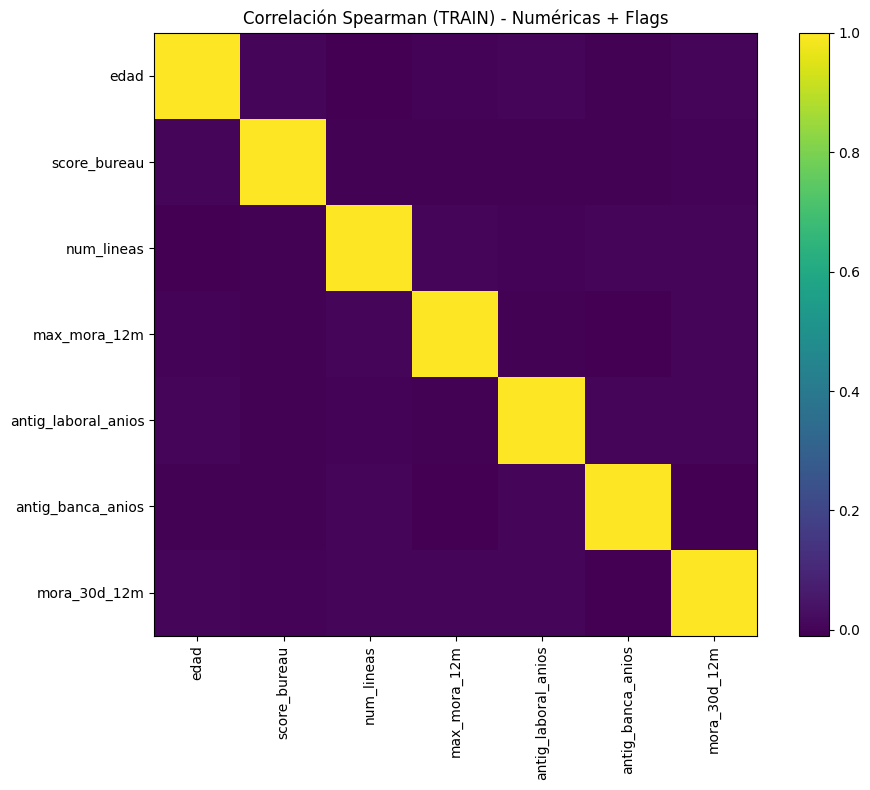

Pares con |corr| > 0.85:


,Var1,Var2,Corr


In [7]:
# ==========================================
# 6) Matriz de correlación (Spearman) - numéricas + flags
# ==========================================
cols_corr = [c for c in (num_cols + flag_cols) if c in train_df.columns]

if len(cols_corr) == 0:
    print("No hay columnas numéricas/flags para correlación.")
else:
    corr_matrix = train_df[cols_corr].replace([np.inf, -np.inf], np.nan).corr(method="spearman")

    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix.values)
    plt.colorbar()
    plt.xticks(range(len(cols_corr)), cols_corr, rotation=90)
    plt.yticks(range(len(cols_corr)), cols_corr)
    plt.title("Correlación Spearman (TRAIN) - Numéricas + Flags")
    plt.tight_layout()
    plt.show()

    # Pares altamente correlacionados
    threshold = 0.85
    pairs = []
    for i in range(len(cols_corr)):
        for j in range(i+1, len(cols_corr)):
            v = corr_matrix.iloc[i, j]
            if pd.notna(v) and abs(v) > threshold:
                pairs.append((cols_corr[i], cols_corr[j], float(v)))

    high_corr_df = pd.DataFrame(pairs, columns=["Var1","Var2","Corr"]).sort_values("Corr", key=lambda s: s.abs(), ascending=False)
    print(f"Pares con |corr| > {threshold}:")
    display(high_corr_df)


In [8]:
# ==========================================
# (Opcional) VIF - Variance Inflation Factor (solo numéricas)
# ==========================================
if not STATS_MODELS_OK:
    print("statsmodels no disponible. Omitiendo VIF.")
elif len(num_cols) < 2:
    print("Muy pocas numéricas para VIF.")
else:
    # VIF es sensible a escala: estandarizamos primero
    X_vif = train_df[num_cols].replace([np.inf, -np.inf], np.nan).dropna()
    if len(X_vif) == 0:
        print("No hay filas completas para VIF (revisa NaN/Inf).")
    else:
        X_scaled = StandardScaler().fit_transform(X_vif)

        vif_data = pd.DataFrame({
            "variable": num_cols,
            "VIF": [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
        }).sort_values("VIF", ascending=False)

        display(vif_data)
        print("Regla práctica: VIF>10 suele indicar multicolinealidad severa (revisar, no eliminar a ciegas).")


,variable,VIF
2,num_lineas,1.000277
5,antig_banca_anios,1.000266
0,edad,1.000223
1,score_bureau,1.000152
3,max_mora_12m,1.000133
4,antig_laboral_anios,1.000089


Regla práctica: VIF>10 suele indicar multicolinealidad severa (revisar, no eliminar a ciegas).


## 7) Correlación de TODAS las variables vs target (heatmap + ranking)

Para tener una vista única:
- Convertimos categóricas a códigos numéricos (factorize) **solo para diagnóstico**
- Calculamos correlación Spearman contra el target
- Graficamos el top de variables asociadas

> Esto NO reemplaza a métodos apropiados para categóricas (Cramér’s V / MI), pero ayuda a priorizar.


,corr_spearman,abs_corr
score_bureau,-0.191750,0.191750
utilizacion_tc,0.121638,0.121638
max_mora_12m,0.080586,0.080586
ingreso_mensual,-0.053152,0.053152
saldo_total,0.045484,0.045484
num_lineas,-0.008753,0.008753
region,0.007499,0.007499
antig_laboral_anios,0.006660,0.006660
edad,-0.006239,0.006239
antig_banca_anios,0.003415,0.003415


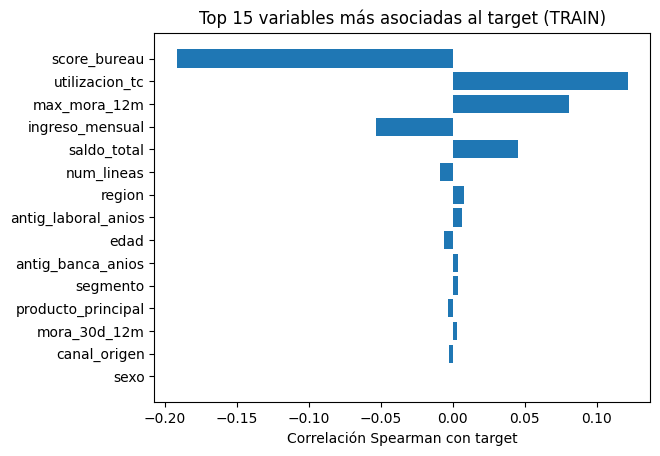

In [9]:
# ==========================================
# 7) Correlación Spearman vs target (incluye categóricas codificadas)
# ==========================================
drop_cols = ["id_cliente", time_col, target]
X_corr = train_df.drop(columns=drop_cols, errors="ignore").copy()
X_corr = X_corr.replace([np.inf, -np.inf], np.nan)

# Codificar categóricas -> numéricas (factorize)
X_corr_encoded = X_corr.copy()
cat_cols_ok = [c for c in cat_cols if c in X_corr_encoded.columns]
for c in cat_cols_ok:
    codes, _ = pd.factorize(X_corr_encoded[c].astype("string"), sort=True)
    X_corr_encoded[c] = codes  # NaN queda como -1

# Unir target + features
df_corr = train_df[[target]].join(X_corr_encoded).copy()

# Limpieza de strings vacíos (por si se coló alguno)
df_corr = df_corr.replace(r"^\s*$", np.nan, regex=True)

# Forzar a numérico (lo que no se pueda -> NaN)
for c in df_corr.columns:
    df_corr[c] = pd.to_numeric(df_corr[c], errors="coerce")

# Imputación rápida para correlación
df_corr = df_corr.fillna(df_corr.median(numeric_only=True))

corr_target = df_corr.corr(method="spearman")[target].drop(target)
corr_target_abs = corr_target.abs().sort_values(ascending=False)

top_n = 15
top_corr = pd.DataFrame({
    "corr_spearman": corr_target.loc[corr_target_abs.index],
    "abs_corr": corr_target_abs
}).head(top_n)

display(top_corr)

plt.figure()
plt.barh(top_corr.index, top_corr["corr_spearman"])
plt.xlabel("Correlación Spearman con target")
plt.title(f"Top {top_n} variables más asociadas al target (TRAIN)")
plt.gca().invert_yaxis()
plt.show()


Dimensión matriz: (7, 7)


,sexo,region,segmento,ingreso_mensual,utilizacion_tc,producto_principal,canal_origen
sexo,1.000000,-0.000532,0.004234,0.013378,-0.009104,-0.002304,-0.003494
region,-0.000532,1.000000,0.005403,-0.004714,0.000790,0.004003,-0.002315
segmento,0.004234,0.005403,1.000000,-0.003642,-0.010011,-0.001526,-0.010760
ingreso_mensual,0.013378,-0.004714,-0.003642,1.000000,-0.009866,-0.003148,0.000557
utilizacion_tc,-0.009104,0.000790,-0.010011,-0.009866,1.000000,-0.010859,-0.007616


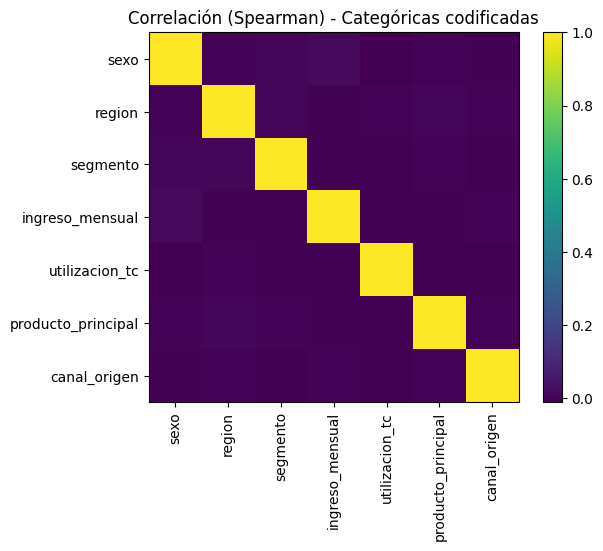

In [10]:
# ==========================================================
# Correlación entre CATEGÓRICAS codificadas (autosuficiente)
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Crear dataset base sin target/id/periodo
drop_cols = ["id_cliente", time_col, target]
X_temp = train_df.drop(columns=drop_cols, errors="ignore").copy()

# 2) Codificar categóricas a números
cat_cols_ok = [c for c in cat_cols if c in X_temp.columns]

X_encoded = X_temp.copy()

for c in cat_cols_ok:
    codes, _ = pd.factorize(X_encoded[c].astype("string"), sort=True)
    X_encoded[c] = codes  # NaN queda como -1 automáticamente

# 3) Forzar numérico por seguridad
X_encoded = X_encoded.apply(pd.to_numeric, errors="coerce")

# 4) Imputar para poder correlacionar
X_encoded = X_encoded.fillna(X_encoded.median())

# 5) Calcular correlación solo categóricas
corr_cat = X_encoded[cat_cols_ok].corr(method="spearman")

print("Dimensión matriz:", corr_cat.shape)
display(corr_cat.head())

# 6) Graficar
plt.figure()
plt.imshow(corr_cat.values)
plt.colorbar()
plt.xticks(range(len(corr_cat.columns)), corr_cat.columns, rotation=90)
plt.yticks(range(len(corr_cat.index)), corr_cat.index)
plt.title("Correlación (Spearman) - Categóricas codificadas")
plt.show()

In [11]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# ==========================================================
# ANOVA: Categóricas vs Numéricas
# ==========================================================

cat_cols_ok = [c for c in cat_cols if c in train_df.columns]
num_cols_ok = [c for c in num_cols if c in train_df.columns]

anova_results = pd.DataFrame(index=cat_cols_ok, columns=num_cols_ok)

for cat in cat_cols_ok:
    for num in num_cols_ok:
        groups = [
            train_df[train_df[cat] == val][num].dropna()
            for val in train_df[cat].dropna().unique()
        ]
        
        # Solo si hay al menos 2 grupos con datos
        if len(groups) >= 2:
            f_stat, p_val = stats.f_oneway(*groups)
            anova_results.loc[cat, num] = f_stat
        else:
            anova_results.loc[cat, num] = np.nan

anova_results = anova_results.astype(float)

display(anova_results.head())

,edad,score_bureau,num_lineas,max_mora_12m,antig_laboral_anios,antig_banca_anios
sexo,0.050592,0.495680,0.616805,0.074676,1.733799,0.005157
region,0.884179,1.285322,1.030851,1.102741,0.772679,0.803642
segmento,0.857097,0.097027,1.890552,1.189934,0.139231,1.580503
ingreso_mensual,1.161090,NaN,1.215104,1.112093,NaN,1.075981
utilizacion_tc,3.621699,NaN,6.405544,7.389417,NaN,3.355863


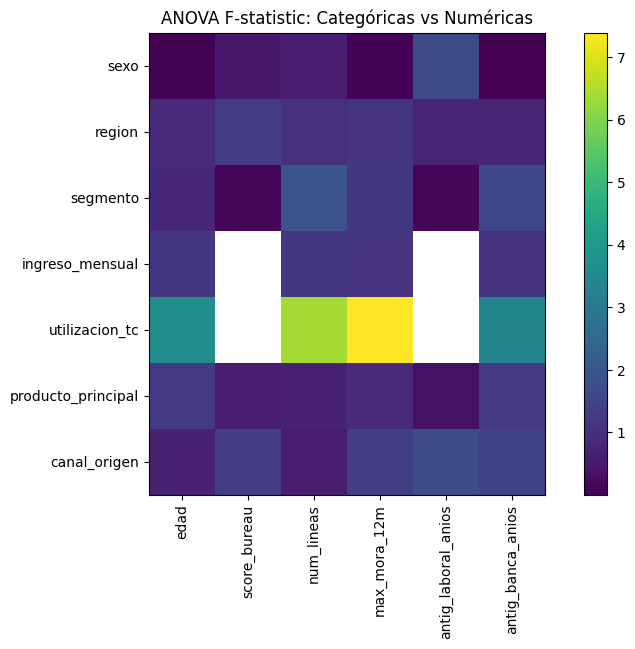

In [12]:
plt.figure(figsize=(10,6))
plt.imshow(anova_results.values)
plt.colorbar()
plt.xticks(range(len(anova_results.columns)), anova_results.columns, rotation=90)
plt.yticks(range(len(anova_results.index)), anova_results.index)
plt.title("ANOVA F-statistic: Categóricas vs Numéricas")
plt.show()

In [13]:
# Top relaciones
anova_long = (
    anova_results.stack()
    .reset_index()
    .rename(columns={"level_0": "categorica",
                     "level_1": "numerica",
                     0: "f_stat"})
    .sort_values("f_stat", ascending=False)
)

display(anova_long.head(10))

,categorica,numerica,f_stat
27,utilizacion_tc,max_mora_12m,7.389417
26,utilizacion_tc,num_lineas,6.405544
24,utilizacion_tc,edad,3.621699
29,utilizacion_tc,antig_banca_anios,3.355863
14,segmento,num_lineas,1.890552
40,canal_origen,antig_laboral_anios,1.747902
4,sexo,antig_laboral_anios,1.733799
17,segmento,antig_banca_anios,1.580503
41,canal_origen,antig_banca_anios,1.496698
39,canal_origen,max_mora_12m,1.404466


<Figure size 640x480 with 0 Axes>

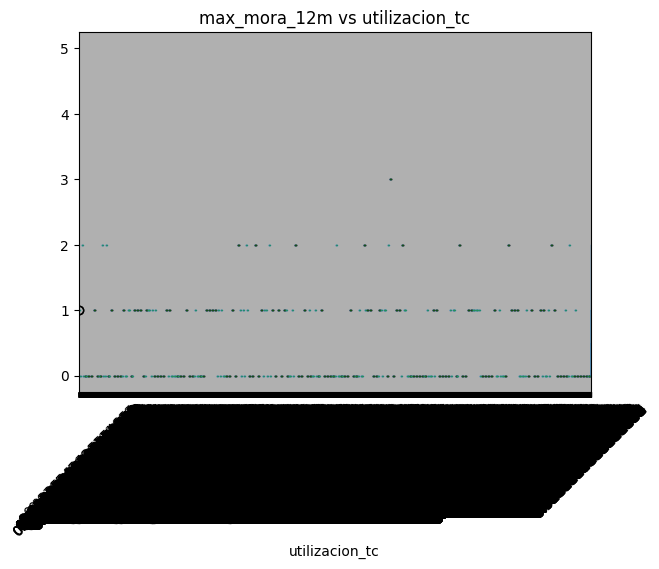

In [14]:
cat_sel = anova_long.iloc[0]["categorica"]
num_sel = anova_long.iloc[0]["numerica"]

plt.figure()
train_df.boxplot(column=num_sel, by=cat_sel)
plt.title(f"{num_sel} vs {cat_sel}")
plt.suptitle("")
plt.xticks(rotation=45)
plt.show()

## 8) Señal predictiva: Mutual Information (MI) (robusta, sin NaN)

La Mutual Information mide dependencia (no lineal) entre features y el target.  
La calcularemos sobre un pipeline que:
- imputación robusta (constant)
- one-hot para categóricas
- sin scaler (no es necesario para MI)

> Si MI ≈ 0: la variable aporta poco (candidato a eliminar si además es inestable / redundante).


In [15]:
# ==========================================
# 8) Mutual Information (MI) robusta
# ==========================================
from sklearn.feature_selection import mutual_info_classif

drop_cols = ["id_cliente", time_col, target]
X_train_full = train_df.drop(columns=drop_cols, errors="ignore").copy()
y_train = train_df[target].astype(int)

# Limpieza crítica
X_train_full = X_train_full.replace([np.inf, -np.inf], np.nan)

# Asegurar columnas existentes (evita mismatch)
num_cols_ok  = [c for c in num_cols  if c in X_train_full.columns]
flag_cols_ok = [c for c in flag_cols if c in X_train_full.columns]
cat_cols_ok  = [c for c in cat_cols  if c in X_train_full.columns]

num_imp  = SimpleImputer(strategy="constant", fill_value=-999)
flag_imp = SimpleImputer(strategy="constant", fill_value=0)
cat_imp  = SimpleImputer(strategy="constant", fill_value="__MISSING__")

preprocess_mi = ColumnTransformer(
    transformers=[
        ("num",  Pipeline([("imp", num_imp)]),  num_cols_ok),
        ("flag", Pipeline([("imp", flag_imp)]), flag_cols_ok),
        ("cat",  Pipeline([
            ("imp", cat_imp),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols_ok),
    ],
    remainder="drop"
)

X_mi = preprocess_mi.fit_transform(X_train_full)

# Chequeo: no NaN/Inf en matriz transformada
if hasattr(X_mi, "data"):  # sparse
    assert np.isnan(X_mi.data).sum() == 0, "Aún hay NaN en X_mi"
    assert np.isinf(X_mi.data).sum() == 0, "Aún hay Inf en X_mi"
else:
    assert np.isnan(X_mi).sum() == 0, "Aún hay NaN en X_mi"
    assert np.isinf(X_mi).sum() == 0, "Aún hay Inf en X_mi"

mi = mutual_info_classif(X_mi, y_train, random_state=42)

# nombres de features
ohe = preprocess_mi.named_transformers_["cat"].named_steps["oh"]
cat_feature_names = ohe.get_feature_names_out(cat_cols_ok)
feature_names = np.r_[num_cols_ok, flag_cols_ok, cat_feature_names]

mi_df = pd.DataFrame({
    "feature": feature_names,
    "mutual_information": mi
}).sort_values("mutual_information", ascending=False)

display(mi_df.head(30))


,feature,mutual_information
1,score_bureau,0.030046
25553,ingreso_mensual___MISSING__,0.018575
3,max_mora_12m,0.003737
4,antig_laboral_anios,0.003017
5,antig_banca_anios,0.001670
52002,utilizacion_tc_—,0.000892
28,ingreso_mensual_,0.000702
0,edad,0.000691
25555,ingreso_mensual_—,0.000581
25556,utilizacion_tc_,0.000346


## 9) Estabilidad temporal – PSI (Population Stability Index)

Antes de entrenar, verificamos estabilidad en el tiempo para evitar modelos que “se rompen” en producción.

**Interpretación estándar banca:**
- PSI < 0.10 → **OK**
- 0.10 ≤ PSI < 0.25 → **WARNING**
- PSI ≥ 0.25 → **ALERT** (drift fuerte)

Validaciones que haremos:
- TRAIN vs TEST
- TRAIN vs OOT
- PSI mensual vs TRAIN
- PSI del target
- Drift por segmento (cambio de mix + cambio de tasa de mora)
- Reporte tipo comité (OK/WARNING/ALERT) + export a Excel/PDF


In [16]:
# ==========================================
# 9) PSI engine (numéricas + categóricas) reutilizable
# ==========================================
def psi_numeric(base, compare, buckets=10):
    base = pd.Series(base).replace([np.inf, -np.inf], np.nan).dropna()
    compare = pd.Series(compare).replace([np.inf, -np.inf], np.nan).dropna()

    if len(base) == 0 or len(compare) == 0:
        return np.nan

    quantiles = np.linspace(0, 1, buckets + 1)
    breakpoints = np.unique(np.quantile(base, quantiles))

    # si por alguna razón quedan muy pocos bins
    if len(breakpoints) < 3:
        breakpoints = np.unique(np.quantile(base, [0, 0.5, 1.0]))

    base_dist = np.histogram(base, bins=breakpoints)[0] / len(base)
    comp_dist = np.histogram(compare, bins=breakpoints)[0] / len(compare)

    base_dist = np.where(base_dist == 0, 1e-6, base_dist)
    comp_dist = np.where(comp_dist == 0, 1e-6, comp_dist)

    return float(np.sum((base_dist - comp_dist) * np.log(base_dist / comp_dist)))


def psi_categorical(base, compare):
    base = pd.Series(base).astype("string").fillna("__MISSING__")
    compare = pd.Series(compare).astype("string").fillna("__MISSING__")

    base_dist = base.value_counts(normalize=True)
    comp_dist = compare.value_counts(normalize=True)

    cats = set(base_dist.index).union(set(comp_dist.index))
    psi = 0.0
    for cat in cats:
        p = base_dist.get(cat, 1e-6)
        q = comp_dist.get(cat, 1e-6)
        p = 1e-6 if p == 0 else p
        q = 1e-6 if q == 0 else q
        psi += (p - q) * np.log(p / q)
    return float(psi)


def classify_psi(x):
    if pd.isna(x):
        return "NA"
    if x < 0.10:
        return "OK"
    if x < 0.25:
        return "WARNING"
    return "ALERT"


def psi_dataset(base_df, compare_df, num_cols, cat_cols, flag_cols):
    rows = []
    for c in num_cols + flag_cols:
        if c in base_df.columns and c in compare_df.columns:
            v = psi_numeric(base_df[c], compare_df[c])
            rows.append((c, v, classify_psi(v)))
    for c in cat_cols:
        if c in base_df.columns and c in compare_df.columns:
            v = psi_categorical(base_df[c], compare_df[c])
            rows.append((c, v, classify_psi(v)))

    out = pd.DataFrame(rows, columns=["variable","psi","status"]).sort_values("psi", ascending=False)
    return out


=== PSI TRAIN vs TEST (top 20) ===


,variable,psi,status
11,utilizacion_tc,8.708494,ALERT
10,ingreso_mensual,8.499746,ALERT
8,region,0.004354,OK
1,score_bureau,0.003619,OK
4,antig_laboral_anios,0.003077,OK
0,edad,0.003043,OK
13,canal_origen,0.002486,OK
5,antig_banca_anios,0.001838,OK
12,producto_principal,0.001359,OK
9,segmento,0.001294,OK


=== PSI TRAIN vs OOT (top 20) ===


,variable,psi,status
11,utilizacion_tc,8.701105,ALERT
10,ingreso_mensual,8.430021,ALERT
1,score_bureau,0.003987,OK
8,region,0.003598,OK
0,edad,0.003191,OK
5,antig_banca_anios,0.003148,OK
4,antig_laboral_anios,0.002988,OK
9,segmento,0.002930,OK
13,canal_origen,0.002492,OK
12,producto_principal,0.000845,OK



=== RESUMEN TRAIN vs TEST ===
Total variables: 14
OK: 12 (85.7%) | WARNING: 0 (0.0%) | ALERT: 2 (14.3%)

=== RESUMEN TRAIN vs OOT ===
Total variables: 14
OK: 12 (85.7%) | WARNING: 0 (0.0%) | ALERT: 2 (14.3%)


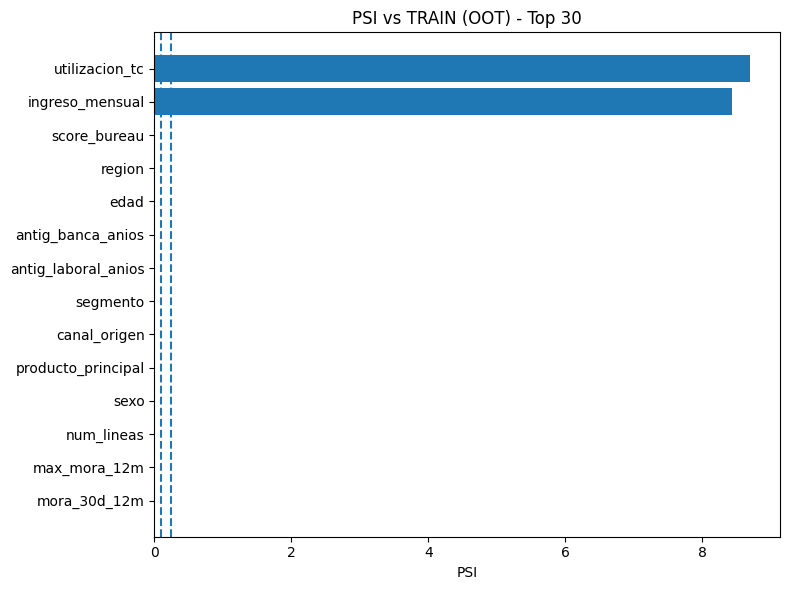

In [17]:
# ==========================================
# 9.1) PSI: TRAIN vs TEST y TRAIN vs OOT
# ==========================================
psi_test = psi_dataset(train_df, test_df, num_cols, cat_cols, flag_cols)
psi_oot  = psi_dataset(train_df, oot_df,  num_cols, cat_cols, flag_cols)

print("=== PSI TRAIN vs TEST (top 20) ===")
display(psi_test.head(20))

print("=== PSI TRAIN vs OOT (top 20) ===")
display(psi_oot.head(20))

def psi_summary(psi_df, name):
    total = len(psi_df)
    ok = (psi_df["status"]=="OK").sum()
    warn = (psi_df["status"]=="WARNING").sum()
    alert = (psi_df["status"]=="ALERT").sum()
    print(f"\n=== RESUMEN {name} ===")
    print(f"Total variables: {total}")
    print(f"OK: {ok} ({ok/total:.1%}) | WARNING: {warn} ({warn/total:.1%}) | ALERT: {alert} ({alert/total:.1%})")

psi_summary(psi_test, "TRAIN vs TEST")
psi_summary(psi_oot,  "TRAIN vs OOT")

# Gráfico comité: PSI OOT (top 30)
top_plot = psi_oot.head(30).copy()

plt.figure(figsize=(8,6))
plt.barh(top_plot["variable"][::-1], top_plot["psi"][::-1])
plt.axvline(0.10, linestyle="--")
plt.axvline(0.25, linestyle="--")
plt.title("PSI vs TRAIN (OOT) - Top 30")
plt.xlabel("PSI")
plt.tight_layout()
plt.show()


,variable,psi,status,periodo
0,utilizacion_tc,9.813729,ALERT,202504
1,ingreso_mensual,9.653087,ALERT,202504
2,region,0.028178,OK,202504
3,edad,0.009823,OK,202504
4,canal_origen,0.007847,OK,202504


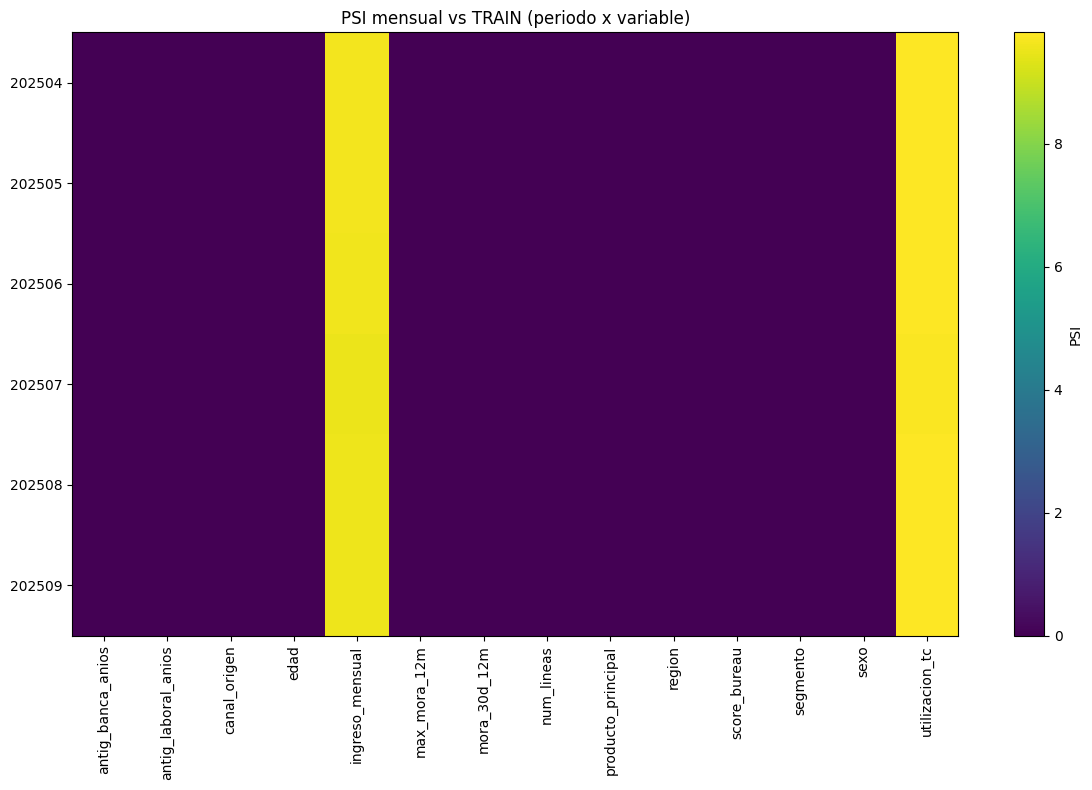

In [18]:
# ==========================================
# 9.2) PSI mensual vs TRAIN (drift dinámico)
# ==========================================
psi_monthly = []
all_periods = sorted(df[time_col].dropna().unique())

for period in all_periods:
    if period in train_periods:
        continue
    month_df = df[df[time_col] == period]
    psi_m = psi_dataset(train_df, month_df, num_cols, cat_cols, flag_cols)
    psi_m["periodo"] = period
    psi_monthly.append(psi_m)

psi_monthly_df = pd.concat(psi_monthly, ignore_index=True)
display(psi_monthly_df.head())

# Heatmap (periodo x variable) para lectura rápida (puede ser grande si hay muchas vars)
pivot = psi_monthly_df.pivot(index="periodo", columns="variable", values="psi")

plt.figure(figsize=(12,8))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="PSI")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("PSI mensual vs TRAIN (periodo x variable)")
plt.tight_layout()
plt.show()


PSI TARGET TRAIN vs TEST: 0.0003 | OK
PSI TARGET TRAIN vs OOT : 0.0 | OK


,periodo,tasa_mora,n
0,202310,0.178500,1507
1,202311,0.155732,1509
2,202312,0.169098,1508
3,202401,0.176080,1505
4,202402,0.195364,1510
5,202403,0.180491,1507
6,202404,0.166887,1510
7,202405,0.183080,1513
8,202406,0.174086,1505
9,202407,0.164565,1507


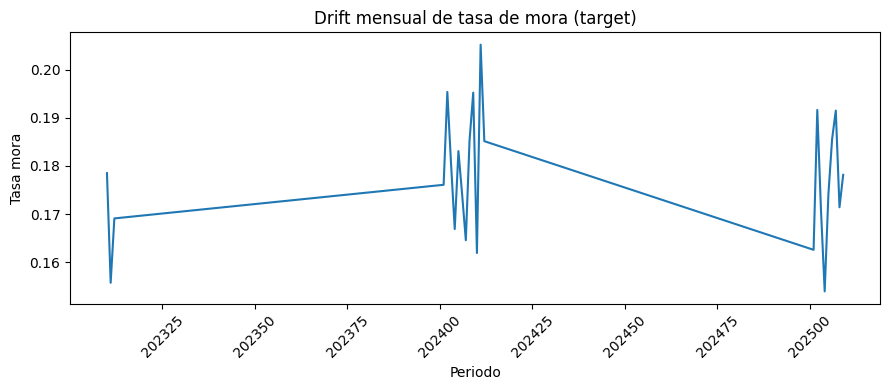

,periodo,psi_target,status
0,202504,4.138105e-03,OK
1,202505,9.977997e-05,OK
2,202506,3.980576e-04,OK
3,202507,1.234077e-03,OK
4,202508,2.887338e-04,OK
5,202509,5.558368e-07,OK


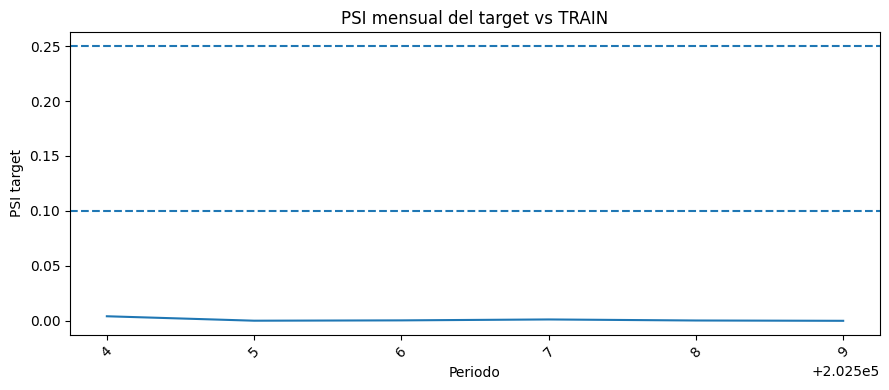


=== REGION ===
PSI MIX TRAIN vs TEST: 0.0044 | OK
PSI MIX TRAIN vs OOT : 0.0036 | OK


,train_mix,oot_mix,train_tasa_mora,oot_tasa_mora,delta_mix,delta_tasa_mora
region,,,,,,
Lima,0.438293,0.424309,0.181665,0.172917,-0.013983,-0.008749
Centro,0.17834,0.180331,0.168871,0.176471,0.001992,0.007599
Norte,0.164848,0.176133,0.179114,0.181932,0.011284,0.002818
Sur,0.138012,0.139669,0.177618,0.200949,0.001656,0.023332
Oriente,0.05909,0.060994,0.180911,0.188406,0.001904,0.007495
__MISSING__,0.010801,0.010387,0.000000,0.000000,-0.000414,0.000000
Lima,0.004829,0.004199,0.175573,0.157895,-0.00063,-0.017678
Centro,0.001548,0.001989,0.166667,0.222222,0.000441,0.055556
Norte,0.002249,0.000884,0.213115,0.250000,-0.001365,0.036885



=== SEGMENTO ===
PSI MIX TRAIN vs TEST: 0.0013 | OK
PSI MIX TRAIN vs OOT : 0.0029 | OK


,train_mix,oot_mix,train_tasa_mora,oot_tasa_mora,delta_mix,delta_tasa_mora
segmento,,,,,,
B,0.442311,0.436022,0.180515,0.172833,-0.006288,-0.007682
C,0.29265,0.306961,0.177478,0.185025,0.014312,0.007547
A,0.245134,0.241105,0.173985,0.186984,-0.004029,0.012999
__MISSING__,0.009658,0.008398,0.000000,0.000000,-0.00126,0.000000
B,0.005013,0.00442,0.176471,0.200000,-0.000593,0.023529
A,0.001917,0.001768,0.134615,0.125000,-0.000149,-0.009615
C,0.003318,0.001326,0.188889,0.333333,-0.001992,0.144444



=== PRODUCTO_PRINCIPAL ===
PSI MIX TRAIN vs TEST: 0.0014 | OK
PSI MIX TRAIN vs OOT : 0.0008 | OK


,train_mix,oot_mix,train_tasa_mora,oot_tasa_mora,delta_mix,delta_tasa_mora
producto_principal,,,,,,
TC,0.54405,0.540331,0.176096,0.182004,-0.003719,0.005908
PL,0.241153,0.241326,0.175023,0.173077,0.000173,-0.001946
Hipotecario,0.115748,0.120442,0.180573,0.157798,0.004694,-0.022775
Pyme,0.078922,0.077127,0.194302,0.220630,-0.001795,0.026329
__MISSING__,0.010358,0.010166,0.000000,0.000000,-0.000193,0.000000
TC,0.005824,0.007072,0.177215,0.218750,0.001248,0.041535
PL,0.002212,0.001768,0.150000,0.250000,-0.000444,0.100000
Hipotecario,0.000995,0.001326,0.222222,0.166667,0.000331,-0.055556
Pyme,0.000737,0.000442,0.050000,0.000000,-0.000295,-0.050000



=== CANAL_ORIGEN ===
PSI MIX TRAIN vs TEST: 0.0025 | OK
PSI MIX TRAIN vs OOT : 0.0025 | OK


,train_mix,oot_mix,train_tasa_mora,oot_tasa_mora,delta_mix,delta_tasa_mora
canal_origen,,,,,,
Digital,0.490195,0.492597,0.181456,0.179901,0.002402,-0.001555
Tienda,0.295304,0.287293,0.175009,0.182308,-0.008011,0.007298
FuerzaVenta,0.147523,0.146961,0.176662,0.181955,-0.000562,0.005293
Alianza,0.047257,0.054365,0.177847,0.142276,0.007107,-0.035571
__MISSING__,0.010395,0.007735,0.000000,0.000000,-0.00266,0.000000
Digital,0.005198,0.005746,0.156028,0.269231,0.000548,0.113202
Tienda,0.002249,0.003094,0.114754,0.142857,0.000845,0.028103
FuerzaVenta,0.001327,0.001768,0.222222,0.375000,0.000441,0.152778
Alianza,0.000553,0.000442,0.000000,0.000000,-0.000111,0.000000



=== SEXO ===
PSI MIX TRAIN vs TEST: 0.0011 | OK
PSI MIX TRAIN vs OOT : 0.0008 | OK


,train_mix,oot_mix,train_tasa_mora,oot_tasa_mora,delta_mix,delta_tasa_mora
sexo,,,,,,
M,0.546004,0.536133,0.178099,0.173949,-0.009872,-0.004150
F,0.443306,0.455028,0.176867,0.189412,0.011722,0.012546
__MISSING__,0.01069,0.00884,0.000000,0.000000,-0.00185,0.000000


In [19]:
# ==========================================
# 9.3) PSI del target + drift por segmento (mix + tasa de mora)
# ==========================================

# PSI del target (binario) usando psi_categorical
psi_target_test = psi_categorical(train_df[target], test_df[target])
psi_target_oot  = psi_categorical(train_df[target], oot_df[target])

print("PSI TARGET TRAIN vs TEST:", round(psi_target_test, 4), "|", classify_psi(psi_target_test))
print("PSI TARGET TRAIN vs OOT :", round(psi_target_oot,  4), "|", classify_psi(psi_target_oot))

# Drift mensual de tasa de mora
target_monthly = (
    df.groupby(time_col)[target]
      .agg(tasa_mora="mean", n="count")
      .reset_index()
      .sort_values(time_col)
)
display(target_monthly)

plt.figure(figsize=(9,4))
plt.plot(target_monthly[time_col], target_monthly["tasa_mora"])
plt.title("Drift mensual de tasa de mora (target)")
plt.xlabel("Periodo")
plt.ylabel("Tasa mora")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# PSI mensual del target vs TRAIN
psi_target_monthly = []
for period in sorted(df[time_col].dropna().unique()):
    if period in train_periods:
        continue
    month_df = df[df[time_col] == period]
    psi_val = psi_categorical(train_df[target], month_df[target])
    psi_target_monthly.append({"periodo": period, "psi_target": psi_val, "status": classify_psi(psi_val)})

psi_target_monthly_df = pd.DataFrame(psi_target_monthly).sort_values("periodo")
display(psi_target_monthly_df)

plt.figure(figsize=(9,4))
plt.plot(psi_target_monthly_df["periodo"], psi_target_monthly_df["psi_target"])
plt.axhline(0.10, linestyle="--")
plt.axhline(0.25, linestyle="--")
plt.title("PSI mensual del target vs TRAIN")
plt.xlabel("Periodo")
plt.ylabel("PSI target")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Drift por segmento (si existen columnas)
segment_cols_to_track = ["region", "segmento", "producto_principal", "canal_origen", "sexo"]

segment_reports = []
for seg in segment_cols_to_track:
    if seg not in df.columns:
        continue

    psi_mix_test = psi_categorical(train_df[seg], test_df[seg])
    psi_mix_oot  = psi_categorical(train_df[seg], oot_df[seg])

    train_mix = train_df[seg].astype("string").fillna("__MISSING__").value_counts(normalize=True).rename("train_mix")
    oot_mix   = oot_df[seg].astype("string").fillna("__MISSING__").value_counts(normalize=True).rename("oot_mix")

    train_rate = train_df.groupby(seg)[target].mean().rename("train_tasa_mora")
    oot_rate   = oot_df.groupby(seg)[target].mean().rename("oot_tasa_mora")

    seg_table = pd.concat([train_mix, oot_mix, train_rate, oot_rate], axis=1).fillna(0)
    seg_table["delta_mix"] = seg_table["oot_mix"] - seg_table["train_mix"]
    seg_table["delta_tasa_mora"] = seg_table["oot_tasa_mora"] - seg_table["train_tasa_mora"]
    seg_table = seg_table.sort_values("oot_mix", ascending=False)

    segment_reports.append((seg, psi_mix_test, psi_mix_oot, seg_table))

    print(f"\n=== {seg.upper()} ===")
    print(f"PSI MIX TRAIN vs TEST: {psi_mix_test:.4f} | {classify_psi(psi_mix_test)}")
    print(f"PSI MIX TRAIN vs OOT : {psi_mix_oot:.4f} | {classify_psi(psi_mix_oot)}")
    display(seg_table.head(15))


In [20]:
# ==========================================
# 9.4) Reporte comité + export (Excel/PDF)
# ==========================================
psi_test2 = psi_test.copy(); psi_test2["scope"] = "TRAIN_vs_TEST"
psi_oot2  = psi_oot.copy();  psi_oot2["scope"]  = "TRAIN_vs_OOT"

committee = pd.concat([psi_test2, psi_oot2], ignore_index=True)

# Agregar target como fila
committee = pd.concat([committee, pd.DataFrame([
    {"variable": target, "psi": psi_target_test, "status": classify_psi(psi_target_test), "scope": "TRAIN_vs_TEST"},
    {"variable": target, "psi": psi_target_oot,  "status": classify_psi(psi_target_oot),  "scope": "TRAIN_vs_OOT"},
])], ignore_index=True)

# Agregar PSI MIX por segmento
mix_rows = []
for seg, psi_mix_test, psi_mix_oot, _ in segment_reports:
    mix_rows.append({"variable": f"MIX::{seg}", "psi": psi_mix_test, "status": classify_psi(psi_mix_test), "scope": "TRAIN_vs_TEST"})
    mix_rows.append({"variable": f"MIX::{seg}", "psi": psi_mix_oot,  "status": classify_psi(psi_mix_oot),  "scope": "TRAIN_vs_OOT"})

committee = pd.concat([committee, pd.DataFrame(mix_rows)], ignore_index=True)

committee = committee.sort_values(["scope","psi"], ascending=[True, False])
print("Resumen comité (top 40):")
display(committee.head(40))

print("\nTop ALERT:")
display(committee[committee["status"]=="ALERT"].head(30))

# Export a Excel
out_xlsx = "reporte_estabilidad_psi_comite.xlsx"
with pd.ExcelWriter(out_xlsx, engine="openpyxl") as writer:
    psi_test.to_excel(writer, sheet_name="PSI_TRAIN_vs_TEST", index=False)
    psi_oot.to_excel(writer, sheet_name="PSI_TRAIN_vs_OOT", index=False)
    psi_monthly_df.to_excel(writer, sheet_name="PSI_MENSUAL_x_VAR", index=False)
    target_monthly.to_excel(writer, sheet_name="TARGET_TASA_MENSUAL", index=False)
    psi_target_monthly_df.to_excel(writer, sheet_name="PSI_TARGET_MENSUAL", index=False)
    committee.to_excel(writer, sheet_name="COMITE_RESUMEN", index=False)
    for seg, _, _, seg_table in segment_reports:
        sheet = f"SEG_{seg}"[:31]
        seg_table.head(50).to_excel(writer, sheet_name=sheet)

print("Excel generado:", out_xlsx)

# PDF comité simple
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from datetime import datetime

pdf_path = "reporte_comite_estabilidad_PSI.pdf"

styles = getSampleStyleSheet()
doc = SimpleDocTemplate(pdf_path, pagesize=A4, rightMargin=36, leftMargin=36, topMargin=36, bottomMargin=36)
elements = []

elements.append(Paragraph("REPORTE DE ESTABILIDAD (PSI) - COMITÉ", styles["Title"]))
elements.append(Spacer(1, 10))
elements.append(Paragraph("Autor: Josef Renato Rodríguez Mallma", styles["Normal"]))
elements.append(Paragraph(f"Fecha: {datetime.now().strftime('%d/%m/%Y')}", styles["Normal"]))
elements.append(Spacer(1, 12))

def summary_line(df_scope, label):
    total = len(df_scope)
    ok = (df_scope["status"]=="OK").sum()
    warn = (df_scope["status"]=="WARNING").sum()
    alert = (df_scope["status"]=="ALERT").sum()
    return [label, total, ok, warn, alert]

exec_rows = [["Scope", "Total", "OK", "WARNING", "ALERT"]]
exec_rows.append(summary_line(committee[committee["scope"]=="TRAIN_vs_TEST"], "TRAIN vs TEST"))
exec_rows.append(summary_line(committee[committee["scope"]=="TRAIN_vs_OOT"],  "TRAIN vs OOT"))

t = Table(exec_rows)
t.setStyle(TableStyle([
    ("BACKGROUND",(0,0),(-1,0),colors.HexColor("#1F4E79")),
    ("TEXTCOLOR",(0,0),(-1,0),colors.white),
    ("GRID",(0,0),(-1,-1),0.5,colors.grey),
    ("FONTNAME",(0,0),(-1,0),"Helvetica-Bold"),
]))
elements.append(Paragraph("Resumen Ejecutivo", styles["Heading2"]))
elements.append(t)
elements.append(Spacer(1, 12))

alerts = committee[committee["status"]=="ALERT"].head(20)
elements.append(Paragraph("Top 20 ALERT (PSI ≥ 0.25)", styles["Heading2"]))

alert_rows = [["Scope", "Variable", "PSI", "Status"]]
for _, r in alerts.iterrows():
    alert_rows.append([r["scope"], str(r["variable"]), f"{float(r['psi']):.4f}", r["status"]])

t2 = Table(alert_rows, colWidths=[90, 250, 60, 60])
t2.setStyle(TableStyle([
    ("BACKGROUND",(0,0),(-1,0),colors.HexColor("#7A0C0C")),
    ("TEXTCOLOR",(0,0),(-1,0),colors.white),
    ("GRID",(0,0),(-1,-1),0.5,colors.grey),
    ("FONTNAME",(0,0),(-1,0),"Helvetica-Bold"),
    ("FONTSIZE",(0,0),(-1,-1),8),
    ("VALIGN",(0,0),(-1,-1),"TOP"),
]))
elements.append(t2)

doc.build(elements)
print("PDF generado:", pdf_path)


Resumen comité (top 40):


,variable,psi,status,scope
14,utilizacion_tc,8.701105,ALERT,TRAIN_vs_OOT
15,ingreso_mensual,8.430021,ALERT,TRAIN_vs_OOT
16,score_bureau,0.003987,OK,TRAIN_vs_OOT
17,region,0.003598,OK,TRAIN_vs_OOT
31,MIX::region,0.003598,OK,TRAIN_vs_OOT
18,edad,0.003191,OK,TRAIN_vs_OOT
19,antig_banca_anios,0.003148,OK,TRAIN_vs_OOT
20,antig_laboral_anios,0.002988,OK,TRAIN_vs_OOT
21,segmento,0.002930,OK,TRAIN_vs_OOT
33,MIX::segmento,0.002930,OK,TRAIN_vs_OOT



Top ALERT:


,variable,psi,status,scope
14,utilizacion_tc,8.701105,ALERT,TRAIN_vs_OOT
15,ingreso_mensual,8.430021,ALERT,TRAIN_vs_OOT
0,utilizacion_tc,8.708494,ALERT,TRAIN_vs_TEST
1,ingreso_mensual,8.499746,ALERT,TRAIN_vs_TEST


Excel generado: reporte_estabilidad_psi_comite.xlsx
PDF generado: reporte_comite_estabilidad_PSI.pdf


## 10) Preprocesamiento profesional (LR vs Árboles)

- Logistic Regression es sensible a escala → **escalar solo numéricas** (no flags)  
- Modelos de árboles no necesitan scaler → imputación + onehot basta  

Definimos dos `ColumnTransformer`:
- `preprocess_lr`
- `preprocess_tree`


In [21]:
# ==========================================
# 10) Preprocesadores (LR vs Árboles)
# ==========================================
numeric_transformer_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

flag_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_lr = ColumnTransformer(
    transformers=[
        ("num",  numeric_transformer_lr, num_cols),
        ("flag", flag_transformer,       flag_cols),
        ("cat",  categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

numeric_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num",  numeric_transformer_tree, num_cols),
        ("flag", flag_transformer,         flag_cols),
        ("cat",  categorical_transformer,  cat_cols),
    ],
    remainder="drop"
)

preprocess_lr, preprocess_tree


(ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', StandardScaler())]),
                                  ['edad', 'score_bureau', 'num_lineas',
                                   'max_mora_12m', 'antig_laboral_anios',
                                   'antig_banca_anios']),
                                 ('flag',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent'))]),
                                  ['mora_30d_12m']),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehot',
               

## 11) Modelamiento y evaluación (TEST y OOT)

Entrenamos en TRAIN y evaluamos en:
- **TEST**: validación interna
- **OOT**: validación final (out-of-time)

Métricas recomendadas para desbalance:
- ROC-AUC
- PR-AUC (Average Precision)


In [22]:
# ==========================================
# 11) Entrenamiento y evaluación (TRAIN -> TEST/OOT) 
# ==========================================

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score


class ToDenseTransformer(BaseEstimator, TransformerMixin):
    """
    HistGradientBoostingClassifier NO acepta matrices sparse.
    Este transformer convierte sparse -> dense (numpy array) cuando sea necesario.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.toarray() if hasattr(X, "toarray") else X


def eval_model(name, model, X_train, y_train, X_test, y_test, X_oot, y_oot):
    """
    Entrena el pipeline y evalúa con métricas estándar para clasificación binaria.
    Retorna:
    - dict con métricas (para tabla comparativa)
    - proba en TEST
    - proba en OOT
    """
    model.fit(X_train, y_train)

    # Probabilidad de la clase positiva (1)
    test_proba = model.predict_proba(X_test)[:, 1]
    oot_proba  = model.predict_proba(X_oot)[:, 1]

    out = {
        "modelo": name,
        "TEST_ROC_AUC": roc_auc_score(y_test, test_proba),
        "TEST_PR_AUC":  average_precision_score(y_test, test_proba),
        "OOT_ROC_AUC":  roc_auc_score(y_oot, oot_proba),
        "OOT_PR_AUC":   average_precision_score(y_oot, oot_proba),
    }
    return out, test_proba, oot_proba


results = []

# -------------------
# 1) Baseline: Logistic Regression
# - Usa preprocess_lr (scaler SOLO en numéricas, flags sin scaler)
# -------------------
lr = LogisticRegression(
    max_iter=400,
    class_weight="balanced",
    solver="lbfgs"
)

lr_model = Pipeline(steps=[
    ("preprocess", preprocess_lr),
    ("model", lr)
])

lr_res, lr_test_proba, lr_oot_proba = eval_model(
    "LogisticRegression", lr_model,
    X_train, y_train, X_test, y_test, X_oot, y_oot
)
results.append(lr_res)

# -------------------
# 2) RandomForest
# - Usa preprocess_tree (sin scaler)
# - RandomForest acepta sparse, así que NO convertimos a dense
# -------------------
rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=30,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)

rf_model = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", rf)
])

rf_res, rf_test_proba, rf_oot_proba = eval_model(
    "RandomForest", rf_model,
    X_train, y_train, X_test, y_test, X_oot, y_oot
)
results.append(rf_res)

# -------------------
# 3) HistGradientBoosting
# - Usa preprocess_tree (sin scaler)
# - PERO requiere dense -> insertamos ToDenseTransformer()
# -------------------
hgb = HistGradientBoostingClassifier(
    learning_rate=0.08,
    max_depth=6,
    max_iter=350,
    random_state=42
)

hgb_model = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("to_dense", ToDenseTransformer()),   # <-- FIX definitivo
    ("model", hgb)
])

hgb_res, hgb_test_proba, hgb_oot_proba = eval_model(
    "HistGradientBoosting", hgb_model,
    X_train, y_train, X_test, y_test, X_oot, y_oot
)
results.append(hgb_res)

# -------------------
# Comparación final
# -------------------
comp = pd.DataFrame(results).sort_values("OOT_ROC_AUC", ascending=False)
display(comp)

,modelo,TEST_ROC_AUC,TEST_PR_AUC,OOT_ROC_AUC,OOT_PR_AUC
0,LogisticRegression,0.700550,0.401842,0.696850,0.393442
2,HistGradientBoosting,0.692566,0.379512,0.689866,0.383927
1,RandomForest,0.581863,0.300624,0.567702,0.300269


Mejor modelo (por OOT_ROC_AUC): LogisticRegression


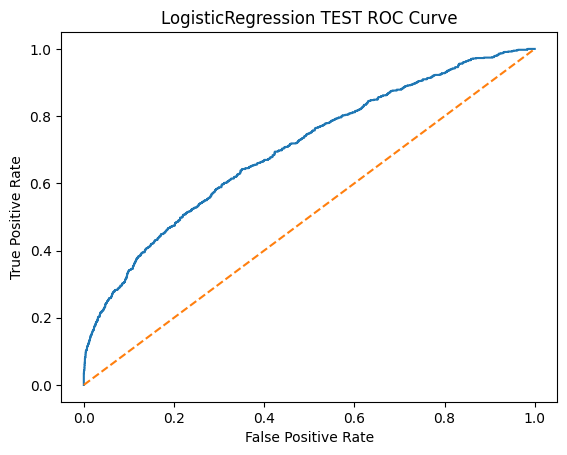

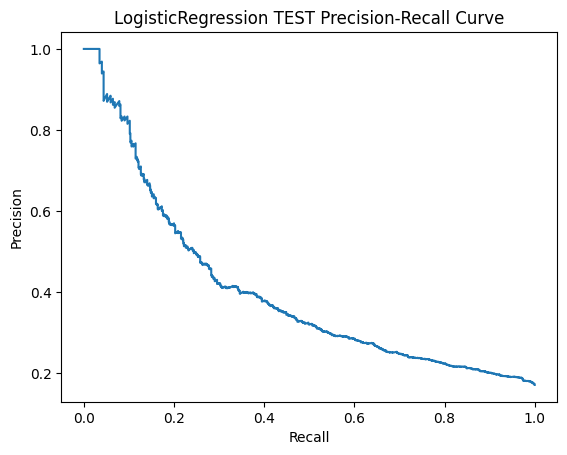

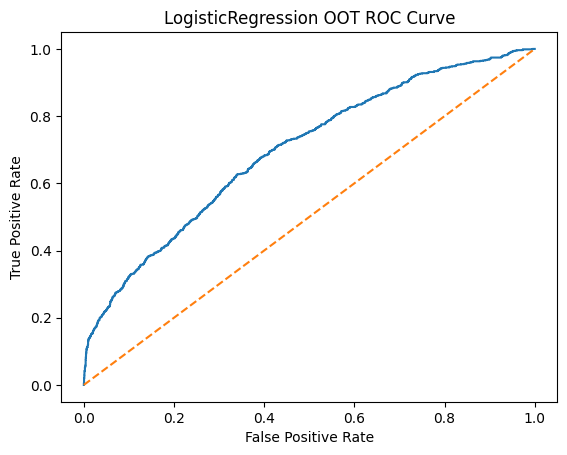

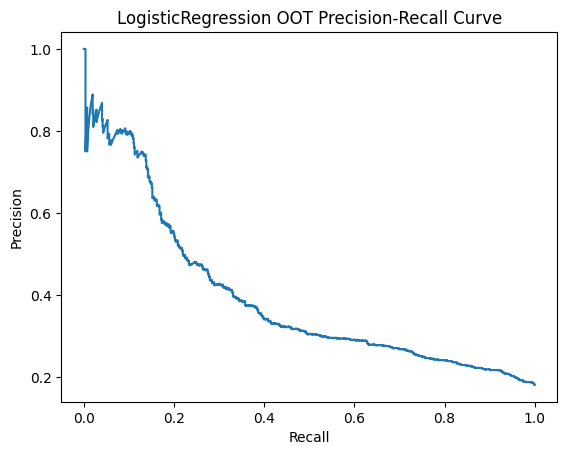

In [23]:
# ==========================================
# Curvas ROC/PR para el mejor modelo (según OOT_ROC_AUC)
# ==========================================
best_name = comp.iloc[0]["modelo"]
print("Mejor modelo (por OOT_ROC_AUC):", best_name)

def plot_roc_pr(y_true, proba, title_prefix=""):
    fpr, tpr, _ = roc_curve(y_true, proba)
    prec, rec, _ = precision_recall_curve(y_true, proba)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.title(f"{title_prefix} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    plt.figure()
    plt.plot(rec, prec)
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

# Mapear proba según modelo
proba_map_test = {
    "LogisticRegression": lr_test_proba,
    "RandomForest": rf_test_proba,
    "HistGradientBoosting": hgb_test_proba
}
proba_map_oot = {
    "LogisticRegression": lr_oot_proba,
    "RandomForest": rf_oot_proba,
    "HistGradientBoosting": hgb_oot_proba
}

plot_roc_pr(y_test, proba_map_test[best_name], f"{best_name} TEST")
plot_roc_pr(y_oot,  proba_map_oot[best_name],  f"{best_name} OOT")


In [24]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# -------------------------------------------------
# helpers de desbalance (opcional pero recomendado)
# -------------------------------------------------
# scale_pos_weight = (#neg / #pos) en TRAIN
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / max(pos, 1))
print("scale_pos_weight (train):", round(scale_pos_weight, 3))

# -------------------
# 4) XGBoost
# -------------------
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="aucpr",          # más relevante con desbalance
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb_model = Pipeline(steps=[
    ("preprocess", preprocess_tree),   # OHE + imputación, retorna sparse y XGBoost lo soporta
    ("model", xgb)
])

xgb_res, xgb_test_proba, xgb_oot_proba = eval_model(
    "XGBoost", xgb_model,
    X_train, y_train, X_test, y_test, X_oot, y_oot
)
results.append(xgb_res)

# -------------------
# 5) LightGBM
# -------------------
lgbm = LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary",
    class_weight="balanced",       # alternativa a scale_pos_weight
    random_state=42,
    n_jobs=-1
)

lgbm_model = Pipeline(steps=[
    ("preprocess", preprocess_tree),   # LightGBM suele aceptar sparse CSR OK
    ("model", lgbm)
])

lgbm_res, lgbm_test_proba, lgbm_oot_proba = eval_model(
    "LightGBM", lgbm_model,
    X_train, y_train, X_test, y_test, X_oot, y_oot
)
results.append(lgbm_res)

# Comparación final actualizada
comp = pd.DataFrame(results).sort_values("OOT_ROC_AUC", ascending=False)
display(comp)

scale_pos_weight (train): 4.622
[LightGBM] [Info] Number of positive: 4825, number of negative: 22303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 27128, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,modelo,TEST_ROC_AUC,TEST_PR_AUC,OOT_ROC_AUC,OOT_PR_AUC
0,LogisticRegression,0.700550,0.401842,0.696850,0.393442
3,XGBoost,0.697943,0.386762,0.690189,0.383662
2,HistGradientBoosting,0.692566,0.379512,0.689866,0.383927
4,LightGBM,0.679185,0.362900,0.675659,0.366762
1,RandomForest,0.581863,0.300624,0.567702,0.300269


## 12) Umbral (threshold): elegir en TEST y reportar en OOT

En riesgo no usamos necesariamente 0.5.  
Elegimos el umbral en **TEST** (validación interna) y reportamos performance con ese umbral en **OOT**.


In [25]:
# ==========================================
# 12) Selección de umbral en TEST -> reporte en OOT
# ==========================================
def evaluate_threshold(y_true, proba, t):
    pred = (proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1 = 2*precision*recall / (precision+recall+1e-9)
    return precision, recall, f1, (tn, fp, fn, tp)

best_test_proba = proba_map_test[best_name]
best_oot_proba  = proba_map_oot[best_name]

ts = np.linspace(0.05, 0.95, 19)
rows = []
for t in ts:
    p,r,f1,_ = evaluate_threshold(y_test, best_test_proba, t)
    rows.append((t,p,r,f1))

thr_df = pd.DataFrame(rows, columns=["threshold","precision","recall","f1"]).sort_values("f1", ascending=False)
display(thr_df.head(10))

best_t = float(thr_df.iloc[0]["threshold"])
print("Mejor threshold (por F1 en TEST):", best_t)

p1,r1,f11,cm1 = evaluate_threshold(y_test, best_test_proba, best_t)
p2,r2,f12,cm2 = evaluate_threshold(y_oot,  best_oot_proba,  best_t)

print(f"TEST @t={best_t:.2f} -> precision={p1:.3f}, recall={r1:.3f}, f1={f11:.3f} | CM(TN,FP,FN,TP)={cm1}")
print(f"OOT  @t={best_t:.2f} -> precision={p2:.3f}, recall={r2:.3f}, f1={f12:.3f} | CM(TN,FP,FN,TP)={cm2}")


,threshold,precision,recall,f1
7,0.40,0.318994,0.507097,0.391629
8,0.45,0.370198,0.410323,0.389229
6,0.35,0.279179,0.614194,0.383871
5,0.30,0.243753,0.717419,0.363874
9,0.50,0.410891,0.321290,0.360608
4,0.25,0.216408,0.827097,0.343056
10,0.55,0.492424,0.251613,0.333049
3,0.20,0.198259,0.910968,0.325646
2,0.15,0.184461,0.974194,0.310189
1,0.10,0.174768,0.997419,0.297422


Mejor threshold (por F1 en TEST): 0.39999999999999997
TEST @t=0.40 -> precision=0.319, recall=0.507, f1=0.392 | CM(TN,FP,FN,TP)=(np.int64(2913), np.int64(839), np.int64(382), np.int64(393))
OOT  @t=0.40 -> precision=0.317, recall=0.464, f1=0.377 | CM(TN,FP,FN,TP)=(np.int64(2891), np.int64(818), np.int64(437), np.int64(379))


## 13) Interpretabilidad

- Logistic Regression: coeficientes (dirección del efecto)  
- Cualquier modelo: permutation importance (impacto en métrica al permutar)

> Nota: con one-hot, las features se expanden; para comité muchas veces se reporta por variable original o por top categorías.


In [26]:
# ==========================================
# 13) Coeficientes (solo Logistic Regression)
# ==========================================
# Extraer nombres de features transformadas (LR)
pre_lr = lr_model.named_steps["preprocess"]
pre_lr.fit(X_train)

# nombres num + flag + onehot(cat)
ohe = pre_lr.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.r_[num_cols, flag_cols, cat_feature_names]

coefs = lr_model.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)
display(coef_df.head(15))
display(coef_df.tail(15))


,feature,coef
25,ingreso_mensual_,3.604223
25551,ingreso_mensual_—,2.474644
6499,ingreso_mensual_1745.57,1.605451
9336,ingreso_mensual_2052.0,1.559252
1203,ingreso_mensual_1157.23,1.541519
6705,ingreso_mensual_1764.33,1.515578
19207,ingreso_mensual_3751.34,1.460137
6953,ingreso_mensual_1788.1,1.454502
4990,ingreso_mensual_1583.65,1.425332
12981,ingreso_mensual_2509.43,1.425007


,feature,coef
30587,utilizacion_tc_0.16468226824727836,-0.519019
43135,utilizacion_tc_0.40244167179008267,-0.520050
39855,utilizacion_tc_0.33592162351015437,-0.521632
12724,ingreso_mensual_2476.72,-0.521632
2634,ingreso_mensual_1329.75,-0.530723
2389,ingreso_mensual_1300.61,-0.535906
19154,ingreso_mensual_3735.93,-0.562293
52000,producto_principal_ Pyme,-0.572941
260,ingreso_mensual_1031.09,-0.590973
27437,utilizacion_tc_0.09306488077712723,-0.590973


,feature,importance_mean,importance_std
5,score_bureau,0.130067,0.010576
4,ingreso_mensual,0.039332,0.002086
7,max_mora_12m,0.020032,0.004824
10,utilizacion_tc,0.005178,0.000939
3,segmento,0.000767,0.000433
1,sexo,0.000089,0.000047
8,mora_30d_12m,0.000089,0.000091
9,saldo_total,0.000000,0.000000
0,edad,-0.000073,0.000124
13,producto_principal,-0.000227,0.000789


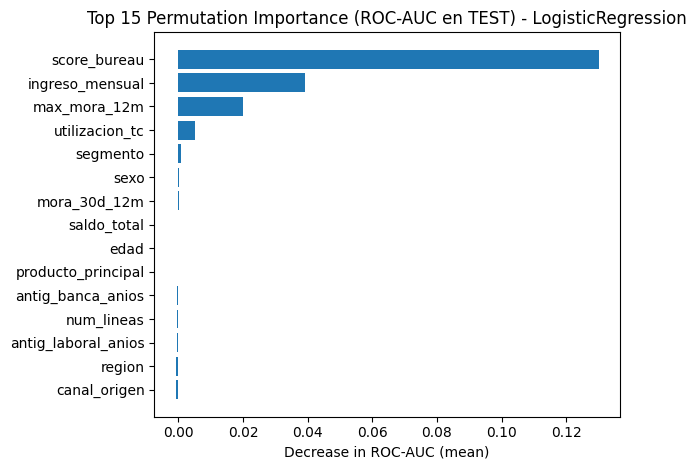

In [27]:
# ==========================================
# 13.1) Permutation Importance en TEST (mejor modelo)
# ==========================================
best_model_map = {
    "LogisticRegression": lr_model,
    "RandomForest": rf_model,
    "HistGradientBoosting": hgb_model
}
best_model = best_model_map[best_name]

result = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=5,
    random_state=42,
    scoring="roc_auc"
)

imp_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_df.head(20))

plt.figure()
plt.barh(imp_df.head(15)["feature"][::-1], imp_df.head(15)["importance_mean"][::-1])
plt.title(f"Top 15 Permutation Importance (ROC-AUC en TEST) - {best_name}")
plt.xlabel("Decrease in ROC-AUC (mean)")
plt.tight_layout()
plt.show()


In [28]:
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(y_oot, lr_oot_proba)
ks = max(tpr - fpr)
print("KS OOT:", round(ks, 4))

KS OOT: 0.2864


## 14) Checklist de producción (banca / MLOps)

**Anti-leakage**
- Split temporal (OK)
- Revisión de variables “post-evento”

**Estabilidad / drift**
- PSI por variable (TRAIN vs OOT)
- PSI mensual + PSI del target
- Drift por segmento

**Calibración y umbral**
- Umbral definido en TEST y validado en OOT
- Si el score se usa como probabilidad: calibración (Platt / Isotonic)

**Trazabilidad**
- Versionado de datos (hash/fecha), features, hiperparámetros, métricas
- Reporte comité (Excel/PDF)

**Monitoreo**
- PSI en producción
- Tasa de mora por cohorte
- Alertas cuando PSI>0.25 o cambios abruptos en mora


## 9. Mejoras avanzadas: Feature Engineering temporal + WOE + PSI + Calibración + Thresholding + KS/Lift/Gini

En esta sección añadimos un **pipeline de validación estilo banca/scorecard**:
- Feature engineering temporal (lags, rolling mean, tendencias, ratios)
- WOE binning + Logistic Regression (estilo credit scoring)
- Monitoreo de drift con PSI (por variable y por score)
- Calibración (Platt / Isotonic) con split temporal (time-safe)
- Optimización de threshold por Expected Loss
- KS, Lift/Gains y Gini


In [29]:

# =========================
# 9.1 Bootstrap: dataset + columnas
# =========================
import numpy as np
import pandas as pd

# Si ya existe df (del notebook anterior), lo usamos.
# Si no, intentamos cargar un CSV de respaldo (si existe).
if "df" not in globals():
    fallback_csv = "dataset_mora.csv"
    try:
        df = pd.read_csv(fallback_csv)
        print(f"[OK] df cargado desde {fallback_csv} (fallback). Shape:", df.shape)
    except Exception as e:
        raise RuntimeError("No existe `df` en memoria y no pude cargar dataset_mora.csv. "
                           "Asegúrate de tener un dataframe `df` cargado antes de esta sección.") from e

# Config por defecto (ajusta si en tu notebook usas otros nombres)
TARGET = globals().get("TARGET", "mora_30d_next3m")
TIME_COL = globals().get("TIME_COL", "periodo")
ID_COL = globals().get("ID_COL", "id_cliente" if "id_cliente" in df.columns else None)

assert TARGET in df.columns, f"No encuentro la variable target: {TARGET}"
assert TIME_COL in df.columns, f"No encuentro la columna temporal: {TIME_COL}"

# Normalizar target a 0/1 si viniera como texto
if df[TARGET].dtype == "O":
    df[TARGET] = df[TARGET].map({"No": 0, "Sí": 1, "Si": 1, "NO": 0, "SI": 1}).astype(int)
df[TARGET] = df[TARGET].astype(int)

df = df.sort_values(TIME_COL).reset_index(drop=True)

print("TARGET:", TARGET, "| TIME_COL:", TIME_COL, "| ID_COL:", ID_COL)
print("Base rate:", df[TARGET].mean().round(4))


TARGET: mora_30d_next3m | TIME_COL: periodo | ID_COL: id_cliente
Base rate: 0.1773


In [30]:

# =========================
# 9.2 Split temporal: TRAIN / TEST / OOT (out-of-time)
# =========================
unique_periods = np.sort(df[TIME_COL].dropna().unique())

# Heurística: 15% OOT y 15% TEST (del remanente)
n_oot = max(1, int(len(unique_periods) * 0.15))
oot_periods = unique_periods[-n_oot:]

remaining = unique_periods[:-n_oot]
n_test = max(1, int(len(remaining) * 0.15))
test_periods = remaining[-n_test:]

train_periods = remaining[:-n_test]

train_df0 = df[df[TIME_COL].isin(train_periods)].copy()
test_df0  = df[df[TIME_COL].isin(test_periods)].copy()
oot_df0   = df[df[TIME_COL].isin(oot_periods)].copy()

print("TRAIN periods:", len(train_periods), "| rows:", train_df0.shape[0])
print("TEST  periods:", len(test_periods),  "| rows:", test_df0.shape[0])
print("OOT   periods:", len(oot_periods),   "| rows:", oot_df0.shape[0])

print("Base rate TRAIN:", train_df0[TARGET].mean().round(4))
print("Base rate TEST :", test_df0[TARGET].mean().round(4))
print("Base rate OOT  :", oot_df0[TARGET].mean().round(4))


TRAIN periods: 18 | rows: 27128
TEST  periods: 3 | rows: 4527
OOT   periods: 3 | rows: 4525
Base rate TRAIN: 0.1779
Base rate TEST : 0.1712
Base rate OOT  : 0.1803


In [31]:

# =========================
# 9.3 Tipos de variables: numéricas vs categóricas
# =========================
drop_cols = [c for c in [ID_COL, TIME_COL, TARGET] if c is not None]
X_cols = [c for c in df.columns if c not in drop_cols]

num_cols = [c for c in X_cols if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in X_cols if not pd.api.types.is_numeric_dtype(df[c])]

# Heurística: numéricas con baja cardinalidad (0/1) tratarlas como categóricas
flag_like = [c for c in num_cols if df[c].nunique(dropna=True) <= 2]
num_cols = [c for c in num_cols if c not in flag_like]
cat_cols = list(dict.fromkeys(cat_cols + flag_like))

print("Numéricas:", len(num_cols), "| Categóricas:", len(cat_cols))


Numéricas: 7 | Categóricas: 8


In [32]:

# =========================
# 9.4 Feature Engineering temporal: lags, rolling, tendencias, ratios
# Nota: requiere ID_COL (id_cliente). Si no existe, se omite.
# =========================
def add_temporal_features(d: pd.DataFrame, base_num_cols, id_col: str, time_col: str):
    d = d.sort_values([id_col, time_col]).copy()
    for c in base_num_cols:
        lag1 = d.groupby(id_col)[c].shift(1)
        roll3 = d.groupby(id_col)[c].shift(1).rolling(3).mean().reset_index(level=0, drop=True)
        d[f"{c}__lag1"] = lag1
        d[f"{c}__roll3_mean_lag"] = roll3
        d[f"{c}__trend1"] = d[c] - lag1
        d[f"{c}__ratio_roll3"] = d[c] / (roll3.abs() + 1e-6)
    return d

if ID_COL is None:
    print("[INFO] No existe ID_COL. Se omite feature engineering temporal por cliente.")
    df_fe = df.copy()
else:
    df_fe = add_temporal_features(df, num_cols, id_col=ID_COL, time_col=TIME_COL)
    print("[OK] df_fe creado. Shape:", df_fe.shape)

# Re-split post-FE (las features usan solo pasado por shift/rolling)
train_df = df_fe[df_fe[TIME_COL].isin(train_periods)].copy()
test_df  = df_fe[df_fe[TIME_COL].isin(test_periods)].copy()
oot_df   = df_fe[df_fe[TIME_COL].isin(oot_periods)].copy()

X_cols_fe = [c for c in df_fe.columns if c not in drop_cols]
num_cols_fe = [c for c in X_cols_fe if pd.api.types.is_numeric_dtype(df_fe[c])]
cat_cols_fe = [c for c in X_cols_fe if c not in num_cols_fe]

print("Features totales:", len(X_cols_fe))
print("Numéricas (FE):", len(num_cols_fe), "| Categóricas (FE):", len(cat_cols_fe))


[OK] df_fe creado. Shape: (36180, 46)
Features totales: 43
Numéricas (FE): 36 | Categóricas (FE): 7


In [33]:

# =========================
# 9.5 WOE binning + Logistic Regression (Scorecard-like)
# =========================
from sklearn.linear_model import LogisticRegression

def woe_table_numeric(x, y, n_bins=10):
    x = pd.Series(x)
    y = pd.Series(y).astype(int)
    mask = x.notna() & np.isfinite(x)
    x = x[mask]; y = y[mask]
    if x.nunique() < 2:
        return {"cuts": None, "woe_map": None, "missing_woe": 0.0}
    cuts = np.unique(np.quantile(x, np.linspace(0, 1, n_bins + 1)))
    if len(cuts) <= 2:
        return {"cuts": None, "woe_map": None, "missing_woe": 0.0}
    b = pd.cut(x, bins=cuts, include_lowest=True, duplicates="drop").astype(str)
    dfb = pd.DataFrame({"bin": b, "y": y.values})
    bad = dfb.groupby("bin")["y"].sum()
    tot = dfb.groupby("bin")["y"].count()
    good = tot - bad
    eps = 0.5
    bad_s = bad + eps
    good_s = good + eps
    bad_rate = bad_s / bad_s.sum()
    good_rate = good_s / good_s.sum()
    woe = np.log(good_rate / bad_rate)
    return {"cuts": cuts, "woe_map": woe.to_dict(), "missing_woe": 0.0}

def woe_table_categorical(x, y, min_freq=0.01):
    x = pd.Series(x).astype("object").fillna("__MISSING__")
    y = pd.Series(y).astype(int)
    freq = x.value_counts(normalize=True)
    rare = set(freq[freq < min_freq].index)
    x2 = x.where(~x.isin(rare), other="__RARE__")
    dfb = pd.DataFrame({"cat": x2, "y": y})
    bad = dfb.groupby("cat")["y"].sum()
    tot = dfb.groupby("cat")["y"].count()
    good = tot - bad
    eps = 0.5
    bad_s = bad + eps
    good_s = good + eps
    bad_rate = bad_s / bad_s.sum()
    good_rate = good_s / good_s.sum()
    woe = np.log(good_rate / bad_rate)
    return {"woe_map": woe.to_dict(), "freq": freq}

def apply_woe_numeric(x, cuts, woe_map, missing_woe=0.0):
    x = pd.Series(x)
    out = pd.Series(np.full(len(x), missing_woe), index=x.index, dtype=float)
    mask = x.notna() & np.isfinite(x)
    if cuts is None or woe_map is None:
        out[mask] = 0.0
        return out
    bins = pd.cut(x[mask], bins=cuts, include_lowest=True, duplicates="drop").astype(str)
    out.loc[mask] = bins.map(woe_map).fillna(0.0).astype(float)
    return out

def apply_woe_cat(x, woe_map, train_freq, min_freq=0.01):
    x = pd.Series(x).astype("object").fillna("__MISSING__")
    rare = set(train_freq[train_freq < min_freq].index)
    x2 = x.where(~x.isin(rare), other="__RARE__")
    return x2.map(woe_map).fillna(0.0).astype(float)

y_train = train_df[TARGET].astype(int)
woe_specs = {}
train_cat_freq = {}

for c in num_cols_fe:
    woe_specs[c] = ("num", woe_table_numeric(train_df[c], y_train, n_bins=10))

for c in cat_cols_fe:
    spec = woe_table_categorical(train_df[c], y_train, min_freq=0.01)
    woe_specs[c] = ("cat", spec)
    train_cat_freq[c] = spec["freq"]

def build_woe_matrix(d):
    Xw={}
    for c,(typ,spec) in woe_specs.items():
        if typ=="num":
            Xw[c] = apply_woe_numeric(d[c], spec["cuts"], spec["woe_map"], spec.get("missing_woe",0.0))
        else:
            Xw[c] = apply_woe_cat(d[c], spec["woe_map"], train_freq=train_cat_freq[c], min_freq=0.01)
    return pd.DataFrame(Xw, index=d.index)

Xw_train = build_woe_matrix(train_df)
Xw_test  = build_woe_matrix(test_df)
Xw_oot   = build_woe_matrix(oot_df)

clf_woe = LogisticRegression(max_iter=3000, class_weight="balanced")
clf_woe.fit(Xw_train, y_train.values)

p_train = clf_woe.predict_proba(Xw_train)[:,1]
p_test  = clf_woe.predict_proba(Xw_test)[:,1]
p_oot   = clf_woe.predict_proba(Xw_oot)[:,1]

print("[OK] Modelo WOE+Logit entrenado.")


[OK] Modelo WOE+Logit entrenado.


In [34]:

# =========================
# 9.6 Métricas: ROC/PR + Gini + Brier + LogLoss + KS
# =========================
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, log_loss

def ks_stat(y, p):
    y = np.asarray(y).astype(int)
    p = np.asarray(p)
    bad = p[y==1]; good = p[y==0]
    if len(bad)==0 or len(good)==0:
        return np.nan
    bad_s = np.sort(bad); good_s = np.sort(good)
    pts = np.sort(np.unique(np.concatenate([bad_s, good_s])))
    cdf_bad = np.searchsorted(bad_s, pts, side="right")/len(bad_s)
    cdf_good = np.searchsorted(good_s, pts, side="right")/len(good_s)
    return float(np.max(np.abs(cdf_bad - cdf_good)))

def block(y, p):
    auc = roc_auc_score(y, p)
    return {
        "ROC_AUC": auc,
        "GINI": 2*auc - 1,
        "PR_AUC": average_precision_score(y, p),
        "Brier": brier_score_loss(y, p),
        "LogLoss": log_loss(y, np.clip(p, 1e-6, 1-1e-6)),
        "KS": ks_stat(y, p),
        "BaseRate": float(np.mean(y))
    }

y_test = test_df[TARGET].astype(int).values
y_oot  = oot_df[TARGET].astype(int).values

m_train = block(y_train.values, p_train)
m_test  = block(y_test, p_test)
m_oot   = block(y_oot, p_oot)

pd.DataFrame([m_train, m_test, m_oot], index=["TRAIN","TEST","OOT"]).round(4)


,ROC_AUC,GINI,PR_AUC,Brier,LogLoss,KS,BaseRate
TRAIN,0.7079,0.4158,0.3962,0.2125,0.6153,0.3018,0.1779
TEST,0.6904,0.3808,0.3745,0.2256,0.6424,0.2874,0.1712
OOT,0.6853,0.3706,0.3782,0.2257,0.6450,0.2782,0.1803


In [35]:

# =========================
# 9.7 PSI (Population Stability Index): drift por variable + drift del score
# Reglas típicas: PSI < 0.1 (OK), 0.1-0.25 (ojo), >0.25 (alerta)
# =========================
def psi_numeric(base, compare, buckets=10):
    base = pd.Series(base).replace([np.inf, -np.inf], np.nan).dropna()
    compare = pd.Series(compare).replace([np.inf, -np.inf], np.nan).dropna()
    if base.nunique() < 2:
        return 0.0
    cuts = np.unique(np.quantile(base, np.linspace(0, 1, buckets + 1)))
    if len(cuts) <= 2:
        return 0.0
    base_bins = pd.cut(base, bins=cuts, include_lowest=True, duplicates="drop")
    comp_bins = pd.cut(compare, bins=cuts, include_lowest=True, duplicates="drop")
    base_dist = base_bins.value_counts(normalize=True).sort_index()
    comp_dist = comp_bins.value_counts(normalize=True).sort_index().reindex(base_dist.index, fill_value=0.0)
    eps = 1e-6
    return float(np.sum((base_dist - comp_dist) * np.log((base_dist + eps) / (comp_dist + eps))))

def psi_categorical(base, compare):
    base = pd.Series(base).astype("object").fillna("__MISSING__")
    compare = pd.Series(compare).astype("object").fillna("__MISSING__")
    base_dist = base.value_counts(normalize=True)
    comp_dist = compare.value_counts(normalize=True).reindex(base_dist.index, fill_value=0.0)
    eps = 1e-6
    return float(np.sum((base_dist - comp_dist) * np.log((base_dist + eps) / (comp_dist + eps))))

def psi_dataset(train_df, other_df, num_cols, cat_cols, buckets=10):
    rows=[]
    for c in num_cols:
        rows.append({"feature": c, "type": "numeric", "psi": psi_numeric(train_df[c], other_df[c], buckets=buckets)})
    for c in cat_cols:
        rows.append({"feature": c, "type": "categorical", "psi": psi_categorical(train_df[c], other_df[c])})
    return pd.DataFrame(rows).sort_values("psi", ascending=False).reset_index(drop=True)

psi_train_test = psi_dataset(train_df, test_df, num_cols_fe, cat_cols_fe)
psi_train_oot  = psi_dataset(train_df, oot_df,  num_cols_fe, cat_cols_fe)

psi_score_train_test = psi_numeric(p_train, p_test, buckets=10)
psi_score_train_oot  = psi_numeric(p_train, p_oot, buckets=10)

print("PSI score TRAIN vs TEST:", round(psi_score_train_test, 4))
print("PSI score TRAIN vs OOT :", round(psi_score_train_oot, 4))

display(psi_train_test.head(20).round(4))


PSI score TRAIN vs TEST: 0.0123
PSI score TRAIN vs OOT : 0.014


,feature,type,psi
0,ingreso_mensual,categorical,3.6573
1,utilizacion_tc,categorical,3.5659
2,antig_banca_anios__roll3_mean_lag,numeric,0.0116
3,saldo_total,numeric,0.0075
4,region,categorical,0.0044
5,saldo_total__roll3_mean_lag,numeric,0.0043
6,edad,numeric,0.0041
7,edad__roll3_mean_lag,numeric,0.0039
8,num_lineas__roll3_mean_lag,numeric,0.0038
9,score_bureau,numeric,0.0038


In [36]:

# =========================
# 9.8 Calibración (time-safe): Platt (sigmoid) e Isotonic
# - Usamos el último 20% de periodos del TRAIN como "calibration set"
# =========================
from sklearn.isotonic import IsotonicRegression

train_periods_sorted = np.sort(train_df[TIME_COL].unique())
n_cal = max(1, int(len(train_periods_sorted) * 0.20))
cal_periods = train_periods_sorted[-n_cal:]
fit_periods = train_periods_sorted[:-n_cal]

fit_df = train_df[train_df[TIME_COL].isin(fit_periods)].copy()
cal_df = train_df[train_df[TIME_COL].isin(cal_periods)].copy()

Xw_fit = build_woe_matrix(fit_df)
y_fit = fit_df[TARGET].astype(int).values
Xw_cal = build_woe_matrix(cal_df)
y_cal = cal_df[TARGET].astype(int).values

base_model = LogisticRegression(max_iter=3000, class_weight="balanced")
base_model.fit(Xw_fit, y_fit)

p_cal = base_model.predict_proba(Xw_cal)[:,1]
p_test_base = base_model.predict_proba(Xw_test)[:,1]
p_oot_base  = base_model.predict_proba(Xw_oot)[:,1]

def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps)
    return np.log(p/(1-p))

# Platt scaling
platt = LogisticRegression(max_iter=2000)
platt.fit(logit(p_cal).reshape(-1,1), y_cal)

def platt_calibrate(p):
    return platt.predict_proba(logit(p).reshape(-1,1))[:,1]

# Isotonic
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(p_cal, y_cal)

def iso_calibrate(p):
    return iso.transform(p)

p_test_platt = platt_calibrate(p_test_base)
p_oot_platt  = platt_calibrate(p_oot_base)

p_test_iso = iso_calibrate(p_test_base)
p_oot_iso  = iso_calibrate(p_oot_base)

# Comparar métricas post-calibración (discriminación ~ igual; calibración mejora Brier/LogLoss)
def compare_models(y_test, y_oot, models_dict):
    rows=[]
    for name,(pt,po) in models_dict.items():
        mt = block(y_test, pt)
        mo = block(y_oot, po)
        rows.append({
            "model": name,
            "TEST_ROC_AUC": mt["ROC_AUC"], "TEST_GINI": mt["GINI"], "TEST_PR_AUC": mt["PR_AUC"], "TEST_Brier": mt["Brier"], "TEST_LogLoss": mt["LogLoss"], "TEST_KS": mt["KS"],
            "OOT_ROC_AUC": mo["ROC_AUC"],  "OOT_GINI": mo["GINI"],  "OOT_PR_AUC": mo["PR_AUC"],  "OOT_Brier": mo["Brier"],  "OOT_LogLoss": mo["LogLoss"],  "OOT_KS": mo["KS"],
        })
    return pd.DataFrame(rows).round(4)

comparison = compare_models(
    y_test, y_oot,
    {
        "Uncalibrated": (p_test, p_oot),
        "Base (refit+split)": (p_test_base, p_oot_base),
        "Platt": (p_test_platt, p_oot_platt),
        "Isotonic": (p_test_iso, p_oot_iso),
    }
)
comparison


,model,TEST_ROC_AUC,TEST_GINI,TEST_PR_AUC,TEST_Brier,TEST_LogLoss,TEST_KS,OOT_ROC_AUC,OOT_GINI,OOT_PR_AUC,OOT_Brier,OOT_LogLoss,OOT_KS
0,Uncalibrated,0.6904,0.3808,0.3745,0.2256,0.6424,0.2874,0.6853,0.3706,0.3782,0.2257,0.6450,0.2782
1,Base (refit+split),0.6900,0.3800,0.3753,0.2261,0.6435,0.2807,0.6846,0.3693,0.3783,0.2264,0.6465,0.2740
2,Platt,0.6900,0.3800,0.3753,0.1281,0.4172,0.2807,0.6846,0.3693,0.3783,0.1336,0.4316,0.2740
3,Isotonic,0.6875,0.3750,0.3479,0.1288,0.4194,0.2772,0.6818,0.3635,0.3566,0.1347,0.4373,0.2676


In [37]:

# =========================
# 9.9 Thresholding: Matriz de confusión por thresholds + Expected Loss
# - En mora suele costar más un FN (dejar pasar morosos) que un FP (bloquear buenos)
# Ajusta COST_FN / COST_FP según el negocio.
# =========================
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def confusion_over_thresholds(y, p, thresholds):
    rows=[]
    for t in thresholds:
        pred = (p>=t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        prec, rec, f1, _ = precision_recall_fscore_support(y, pred, average="binary", zero_division=0)
        rows.append({"thr": t, "tp": tp, "fp": fp, "tn": tn, "fn": fn, "precision": prec, "recall": rec, "f1": f1})
    return pd.DataFrame(rows)

def expected_loss_table(y, p, thresholds, cost_fp=1.0, cost_fn=5.0):
    tab = confusion_over_thresholds(y, p, thresholds)
    tab["expected_loss"] = tab["fp"]*cost_fp + tab["fn"]*cost_fn
    return tab.sort_values("expected_loss").reset_index(drop=True)

thresholds = np.round(np.linspace(0.05, 0.95, 19), 2)

# Recomiendo usar probas calibradas (Platt) para decisioning
thr_tab = confusion_over_thresholds(y_test, p_test_platt, thresholds).round(4)
loss_tab = expected_loss_table(y_test, p_test_platt, thresholds, cost_fp=1.0, cost_fn=5.0).round(4)

display(thr_tab)
print("\nTop 10 thresholds por Expected Loss (FN=5, FP=1):")
display(loss_tab.head(10))

best_thr = float(loss_tab.loc[0,"thr"])
print(">> Threshold óptimo (Expected Loss):", best_thr)

# Mejor threshold por F1 (optimiza PR)
best_f1 = thr_tab.sort_values("f1", ascending=False).head(1)
print("\nMejor threshold por F1:")
display(best_f1)


,thr,tp,fp,tn,fn,precision,recall,f1
0,0.05,765,3616,136,10,0.1746,0.9871,0.2967
1,0.10,697,2781,971,78,0.2004,0.8994,0.3278
2,0.15,570,1787,1965,205,0.2418,0.7355,0.3640
3,0.20,419,1030,2722,356,0.2892,0.5406,0.3768
4,0.25,303,608,3144,472,0.3326,0.3910,0.3594
5,0.30,217,319,3433,558,0.4049,0.2800,0.3310
6,0.35,140,156,3596,635,0.4730,0.1806,0.2614
7,0.40,106,78,3674,669,0.5761,0.1368,0.2211
8,0.45,83,36,3716,692,0.6975,0.1071,0.1857
9,0.50,70,23,3729,705,0.7527,0.0903,0.1613



Top 10 thresholds por Expected Loss (FN=5, FP=1):


,thr,tp,fp,tn,fn,precision,recall,f1,expected_loss
0,0.20,419,1030,2722,356,0.2892,0.5406,0.3768,2810.0
1,0.15,570,1787,1965,205,0.2418,0.7355,0.3640,2812.0
2,0.25,303,608,3144,472,0.3326,0.3910,0.3594,2968.0
3,0.30,217,319,3433,558,0.4049,0.2800,0.3310,3109.0
4,0.10,697,2781,971,78,0.2004,0.8994,0.3278,3171.0
5,0.35,140,156,3596,635,0.4730,0.1806,0.2614,3331.0
6,0.40,106,78,3674,669,0.5761,0.1368,0.2211,3423.0
7,0.45,83,36,3716,692,0.6975,0.1071,0.1857,3496.0
8,0.50,70,23,3729,705,0.7527,0.0903,0.1613,3548.0
9,0.55,67,17,3735,708,0.7976,0.0865,0.1560,3557.0


>> Threshold óptimo (Expected Loss): 0.2

Mejor threshold por F1:


,thr,tp,fp,tn,fn,precision,recall,f1
3,0.2,419,1030,2722,356,0.2892,0.5406,0.3768


In [38]:

# =========================
# 9.10 Lift / Gains por deciles (TEST y OOT)
# =========================
def lift_table(y, p, n_bins=10):
    d = pd.DataFrame({"y": y, "p": p}).sort_values("p", ascending=False).reset_index(drop=True)
    d["decile"] = pd.qcut(d.index, q=n_bins, labels=[f"D{i}" for i in range(1, n_bins+1)])
    overall = d["y"].mean()
    g = d.groupby("decile").agg(
        n=("y","size"),
        events=("y","sum"),
        event_rate=("y","mean"),
        avg_score=("p","mean")
    ).reset_index()
    g["lift"] = g["event_rate"] / (overall + 1e-12)
    g["cum_events"] = g["events"].cumsum()
    g["cum_capture"] = g["cum_events"] / (d["y"].sum() + 1e-12)
    return g, overall

lift_test, br_test = lift_table(y_test, p_test_platt, n_bins=10)
lift_oot, br_oot   = lift_table(y_oot,  p_oot_platt,  n_bins=10)

print("Base rate TEST:", round(br_test,4), "| Base rate OOT:", round(br_oot,4))
display(lift_test.round(4))


Base rate TEST: 0.1712 | Base rate OOT: 0.1803


,decile,n,events,event_rate,avg_score,lift,cum_events,cum_capture
0,D1,453,184,0.4062,0.4456,2.3726,184,0.2374
1,D2,453,117,0.2583,0.2795,1.5087,301,0.3884
2,D3,452,104,0.2301,0.2278,1.3440,405,0.5226
3,D4,453,73,0.1611,0.1912,0.9413,478,0.6168
4,D5,453,76,0.1678,0.1648,0.9800,554,0.7148
5,D6,452,62,0.1372,0.1444,0.8012,616,0.7948
6,D7,453,48,0.1060,0.1245,0.6189,664,0.8568
7,D8,452,46,0.1018,0.1041,0.5945,710,0.9161
8,D9,453,37,0.0817,0.0817,0.4771,747,0.9639
9,D10,453,28,0.0618,0.0545,0.3611,775,1.0000


In [39]:

# =========================
# 9.11 Tablas de calibración + ECE (Expected Calibration Error)
# =========================
def calibration_table(y, p, n_bins=10):
    d = pd.DataFrame({"y": y, "p": p})
    d["bin"] = pd.qcut(d["p"], q=n_bins, duplicates="drop")
    g = d.groupby("bin").agg(n=("y","size"), avg_pred=("p","mean"), obs_rate=("y","mean")).reset_index()
    g["abs_gap"] = (g["avg_pred"] - g["obs_rate"]).abs()
    ece = float((g["n"]/g["n"].sum() * g["abs_gap"]).sum())
    return g, ece

cal_uncal, ece_uncal = calibration_table(y_test, p_test_base, n_bins=10)
cal_platt, ece_platt = calibration_table(y_test, p_test_platt, n_bins=10)
cal_iso,   ece_iso   = calibration_table(y_test, p_test_iso, n_bins=10)

print("ECE (TEST) base :", round(ece_uncal,4))
print("ECE (TEST) Platt:", round(ece_platt,4))
print("ECE (TEST) Iso  :", round(ece_iso,4))

display(cal_platt.round(4))


ECE (TEST) base : 0.3024
ECE (TEST) Platt: 0.0128
ECE (TEST) Iso  : 0.021


,bin,n,avg_pred,obs_rate,abs_gap
0,"(0.0299, 0.069]",453,0.0545,0.0618,0.0073
1,"(0.069, 0.0929]",453,0.0817,0.0817,0.0000
2,"(0.0929, 0.115]",452,0.1041,0.1018,0.0023
3,"(0.115, 0.135]",453,0.1245,0.1060,0.0186
4,"(0.135, 0.154]",453,0.1444,0.1391,0.0053
5,"(0.154, 0.177]",452,0.1648,0.1659,0.0011
6,"(0.177, 0.207]",453,0.1912,0.1611,0.0301
7,"(0.207, 0.25]",452,0.2278,0.2301,0.0023
8,"(0.25, 0.315]",453,0.2795,0.2583,0.0212
9,"(0.315, 0.947]",453,0.4456,0.4062,0.0394


### 9.12 Checklist para producción (muy recomendado)
- **Guardar bins WOE** (cuts y mappings) en artefactos versionados.
- **Monitoreo mensual**: PSI variables + PSI score, KS, Lift top decile, base rate.
- **Recalibración**: si Brier/LogLoss empeoran o drift sube (PSI > 0.25).
- **Threshold dinámico**: revisar con negocio (costos FP/FN) y capacidad operativa.
